## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (CURRENT_YEAR defined in utils.py)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2024-06-13 16:16:12.820657


{1: 24.4,
 5: 25.6,
 10: 26.2,
 20: 27.1,
 30: 28.2,
 40: 29.8,
 50: 31.6,
 60: 33.3,
 70: 35.2,
 80: 37.5,
 90: 41.0,
 95: 43.8,
 99: 49.4}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "(3A) Initial TAI Spend Model" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
sq.get_percentiles(initial_pay)

Cache from: 2024-06-13 23:02:15.622081


{1: 8.2,
 5: 8.3,
 10: 8.4,
 20: 8.6,
 30: 8.7,
 40: 8.8,
 50: 8.9,
 60: 9.0,
 70: 9.1,
 80: 9.3,
 90: 9.5,
 95: 9.7,
 99: 10.1}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2024-06-13 23:05:32.824387


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev1)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=7.56, lognorm_sd=3.93, norm_mean=1.9, norm_sd=0.49) (version 0.28-dev1)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37) (version 0.28-dev1)}}

In [6]:
def wildeford_max_gdp_frac():
    gdp_frac = sq.mixture([[0.9, sq.lognorm(1/500, 1/100)],
                           [0.1, sq.lognorm(1/100, 1/20)]])
    percent_spent_on_compute = sq.lognorm(0.7, 0.99, lclip=0.1, rclip=0.999)
    percent_spent_on_largest_model = sq.lognorm(0.01, 0.8, rclip=0.999)
    compute_frac = gdp_frac * percent_spent_on_compute * percent_spent_on_largest_model
    return {'total_frac': gdp_frac, 'compute_frac': compute_frac}


base_flop_per_dollar = sq.lognorm(18.2, 19.4) # https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
# I'd use 1.43e18 FLOP/$ if renting cloud compute for training (significantly higher for serving a product, and significantly lower if using your own compute -- but then the number depends on how long you amortize it over).
# Source: If renting cloud compute, pricing seems to be $1.89-2.40 per H100 hour. (Jack Clark says $2 with bulk discounts.) Going with $2/hr, with the H100's 1.98e15 FLOP/s (FP8) and assuming 40% utilization (for training), that's 1.98e15*.4*60*60/2 = 1.43e18 FLOP/$.
# https://jack-clark.net/2024/03/28/what-does-1025-versus-1026-mean/ and https://gpus.llm-utils.org/h100-gpu-cloud-availability-and-pricing/
flop_frontier_penalty = sq.norm(0, 1)

# https://docs.google.com/spreadsheets/d/1cLzO_tX9b4z6URKLFvzc0MtsN4GrftkFZuv1bCxeWVY/edit#gid=2058539694
variables = {'initial_gdp': 23.32*T * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03),
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': sq.lognorm(0.75, 3),
             'algo_doubling_rate_min': sq.lognorm(0.5, 2),
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': base_flop_per_dollar - flop_frontier_penalty,
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'],
             'spend_doubling_time': sq.lognorm(0.5, 2, lclip=0.1),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

### GDP

In [7]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000)
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '24.8 trillion',
 5: '24.9 trillion',
 10: '24.9 trillion',
 20: '25.0 trillion',
 30: '25.0 trillion',
 40: '25.1 trillion',
 50: '25.1 trillion',
 60: '25.1 trillion',
 70: '25.2 trillion',
 80: '25.2 trillion',
 90: '25.3 trillion',
 95: '25.3 trillion',
 99: '25.4 trillion'}

#### Total % of GDP spent on entire project

In [8]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 19668.54it/s]


{1: 0.00149,
 5: 0.00208,
 10: 0.00248,
 20: 0.00308,
 30: 0.00357,
 40: 0.00415,
 50: 0.00481,
 60: 0.00561,
 70: 0.00663,
 80: 0.00816,
 90: 0.01294,
 95: 0.02274,
 99: 0.04127}

In [9]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.149%',
 5: '0.208%',
 10: '0.248%',
 20: '0.308%',
 30: '0.357%',
 40: '0.415%',
 50: '0.481%',
 60: '0.561%',
 70: '0.663%',
 80: '0.816%',
 90: '1.294%',
 95: '2.274%',
 99: '4.127%'}

In [10]:
gdp_frac_samples = gdp_samples * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_frac_samples).items()}

{1: '37.4 billion',
 5: '52.4 billion',
 10: '62.5 billion',
 20: '77.4 billion',
 30: '89.6 billion',
 40: '104.3 billion',
 50: '120.5 billion',
 60: '140.6 billion',
 70: '166.3 billion',
 80: '204.9 billion',
 90: '324.8 billion',
 95: '571.0 billion',
 99: '1.0 trillion'}

#### Total % of GDP spent on compute for largest model

In [11]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 6232.88it/s]


{1: '0.001%',
 5: '0.004%',
 10: '0.006%',
 20: '0.011%',
 30: '0.017%',
 40: '0.025%',
 50: '0.037%',
 60: '0.054%',
 70: '0.083%',
 80: '0.13%',
 90: '0.244%',
 95: '0.398%',
 99: '1.049%'}

In [12]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.001%',
 5: '0.004%',
 10: '0.006%',
 20: '0.011%',
 30: '0.017%',
 40: '0.025%',
 50: '0.037%',
 60: '0.054%',
 70: '0.083%',
 80: '0.13%',
 90: '0.244%',
 95: '0.398%',
 99: '1.049%'}

In [13]:
gdp_frac_samples = gdp_samples * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_frac_samples).items()}

{1: '331.9 million',
 5: '921.5 million',
 10: '1.5 billion',
 20: '2.8 billion',
 30: '4.3 billion',
 40: '6.3 billion',
 50: '9.4 billion',
 60: '13.6 billion',
 70: '20.8 billion',
 80: '32.7 billion',
 90: '61.3 billion',
 95: '99.8 billion',
 99: '262.7 billion'}

In [14]:
def model():
    frac = wildeford_max_gdp_frac()
    return frac['total_frac'] / frac['compute_frac']

sq.get_percentiles(sq.sample(model, verbose=True, n=5000), digits=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3691.67it/s]


{1: 0.3,
 5: 1.0,
 10: 1.7,
 20: 3.5,
 30: 6.1,
 40: 9.3,
 50: 14.1,
 60: 21.3,
 70: 32.9,
 80: 54.2,
 90: 112.7,
 95: 216.0,
 99: 736.3}

## Run Wildeford timelines model



## SAMPLE RUN 1 ##

In this simulation:
* It takes 30.3 log FLOP (~2.0 nonillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3.3 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~793.1 million).
* This doubles every 0.2 year to a max of 2.121765% of GDP (initially ~529.7 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 30.3 logFLOP which costs 12.1 log 2025$USD to buy vs. WTP at 8.9 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 29.9 logFLOP which costs 11.6 log 2025$USD to buy vs. WTP at 10.2 (buys 28.5 log FLOP or 28.9 2025-log-eFLOP)
2027 - TAI takes 29.5 logFLOP which costs 11.1 log 2025$USD to buy vs. WTP at 11.3 (buys 29.7 log FLOP or 30.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1583 -

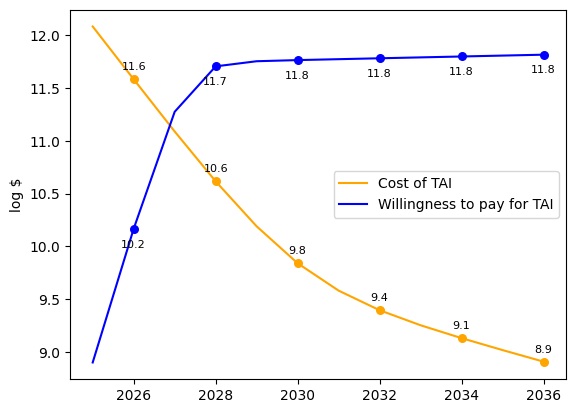



## SAMPLE RUN 2 ##

In this simulation:
* It takes 30.8 log FLOP (~6.3 nonillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.4 quintillion) per 2025$USD.
* Every 3.1 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~16.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.1 log 2025$USD (~139.7 million).
* This doubles every 1.6 year to a max of 0.0047% of GDP (initially ~1.2 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 30.8 logFLOP which costs 12.6 log 2025$USD to buy vs. WTP at 8.1 (buys 26.3 log FLOP or 26.3 2025-log-eFLOP)
2026 - TAI takes 30.6 logFLOP which costs 12.4 log 2025$USD to buy vs. WTP at 8.3 (buys 26.5 log FLOP or 26.7 2025-log-eFLOP)
2027 - TAI takes 30.4 logFLOP which costs 12.1 log 2025$USD to buy vs. WTP at 8.4 (buys 26.8 log FLOP or 27.1 2025-log-eFLOP)
2028 - TAI takes 30.3 logFLOP which costs 11.8 l

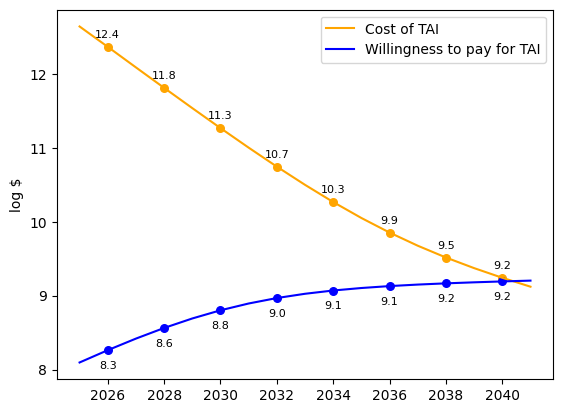



## SAMPLE RUN 3 ##

In this simulation:
* It takes 38.2 log FLOP (~158.5 thousand decillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.3 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~367.3 million).
* This doubles every 0.6 year to a max of 0.019006% of GDP (initially ~4.7 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 38.2 logFLOP which costs 19.6 log 2025$USD to buy vs. WTP at 8.5 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 38.0 logFLOP which costs 19.3 log 2025$USD to buy vs. WTP at 9.0 (buys 27.7 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 37.8 logFLOP which costs 19.0 log 2025$USD to buy vs. WTP at 9.3 (buys 28.2 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 37.7 logFLOP which 

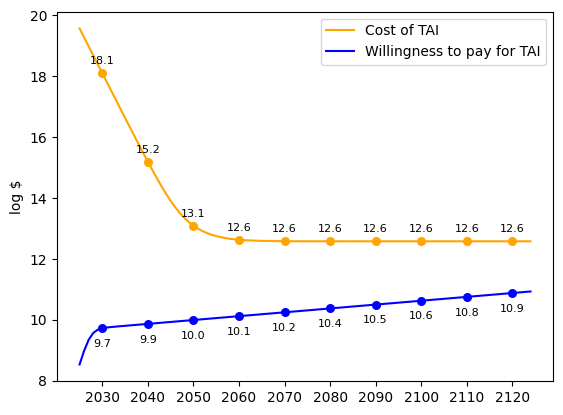



## RUN TIMELINES MODEL ##
Generating Bayes net with 12 cores...


10044it [00:15, 668.77it/s]                                                                                                                                                                                                                          


Shuffling data...
Writing data...
Waiting for other cores...
...Collecting data...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1893.31it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!

## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2029',
 '10%: 2030',
 '15%: 2031',
 '20%: 2032',
 '25%: 2033',
 '35%: 2035',
 '50%: 2041',
 '60%: 2049',
 '75%: 2073',
 '80%: 2105',
 '90%: >2125',
 '95%: >2125']


## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 4 years from now',
 '10%: 5 years from now',
 '15%: 6 years from now',
 '20%: 7 years from now',
 '25%: 8 years from now',
 '35%: 10 years from now',
 '50%: 16 years from now',
 '60%: 24 years from now',
 '75%: 48 years from now',
 '80%: 80 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 34 years from now)


## TAI ARRIVAL DATE BY BIN ##
2025-2026: 1.6%
2027-2029: 5.3%
2030-2034: 25.4%
2035-2039: 15.5%
2040-2049: 13.4%
2050-2059: 9.1%
2060-2069: 3.8%
2070-2079: 2.8%
2080-2089: 2.2%
2090-2099: 0.6%
2100-2109: 0.4%
2110-2119: 0.2%
>2125: 19.7%


## TA



## GDP Over Time ##
Year: 2025 - GDP log 2024$USD 13.4 (~25.1 trillion) 80% CI 13.4 (~25.0 trillion) - 13.4 (~25.2 trillion)
Year: 2026 - GDP log 2024$USD 13.4 (~25.7 trillion) 80% CI 13.4 (~25.4 trillion) - 13.4 (~25.9 trillion)
Year: 2027 - GDP log 2024$USD 13.4 (~26.2 trillion) 80% CI 13.4 (~25.8 trillion) - 13.4 (~26.6 trillion)
Year: 2028 - GDP log 2024$USD 13.4 (~26.8 trillion) 80% CI 13.4 (~26.2 trillion) - 13.4 (~27.4 trillion)
Year: 2029 - GDP log 2024$USD 13.4 (~27.4 trillion) 80% CI 13.4 (~26.7 trillion) - 13.4 (~28.2 trillion)
Year: 2030 - GDP log 2024$USD 13.4 (~28.0 trillion) 80% CI 13.4 (~27.1 trillion) - 13.5 (~29.0 trillion)
Year: 2031 - GDP log 2024$USD 13.5 (~28.7 trillion) 80% CI 13.4 (~27.5 trillion) - 13.5 (~29.8 trillion)
Year: 2032 - GDP log 2024$USD 13.5 (~29.3 trillion) 80% CI 13.4 (~28.0 trillion) - 13.5 (~30.6 trillion)
Year: 2033 - GDP log 2024$USD 13.5 (~30.0 trillion) 80% CI 13.5 (~28.4 trillion) - 13.5 (~31.5 trillion)
Year: 2034 - GDP log 2024$USD 13.

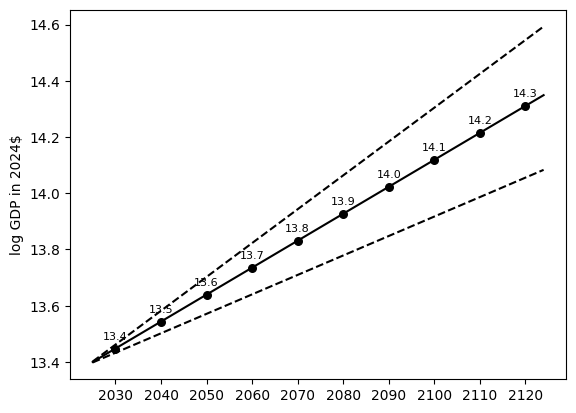

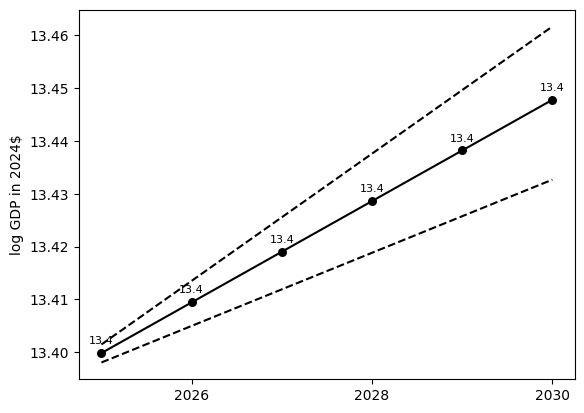



## Willingness to Pay Over Time (Total infrastructure) ##
Year: 2025 - willingness log 2024$USD per year for total infrastructure 10.3 (~18.2 billion) 80% CI 9.5 (~3.4 billion) - 11.1 (~121.0 billion)
Year: 2026 - willingness log 2024$USD per year for total infrastructure 10.5 (~33.7 billion) 80% CI 9.9 (~7.6 billion) - 11.3 (~189.2 billion)
Year: 2027 - willingness log 2024$USD per year for total infrastructure 10.8 (~58.7 billion) 80% CI 10.1 (~13.8 billion) - 11.5 (~292.1 billion)
Year: 2028 - willingness log 2024$USD per year for total infrastructure 11.0 (~94.2 billion) 80% CI 10.3 (~20.0 billion) - 11.6 (~442.6 billion)
Year: 2029 - willingness log 2024$USD per year for total infrastructure 11.1 (~136.0 billion) 80% CI 10.4 (~24.2 billion) - 11.8 (~653.4 billion)
Year: 2030 - willingness log 2024$USD per year for total infrastructure 11.2 (~176.3 billion) 80% CI 10.4 (~26.4 billion) - 12.0 (~932.1 billion)
Year: 2031 - willingness log 2024$USD per year for total infrastructure 

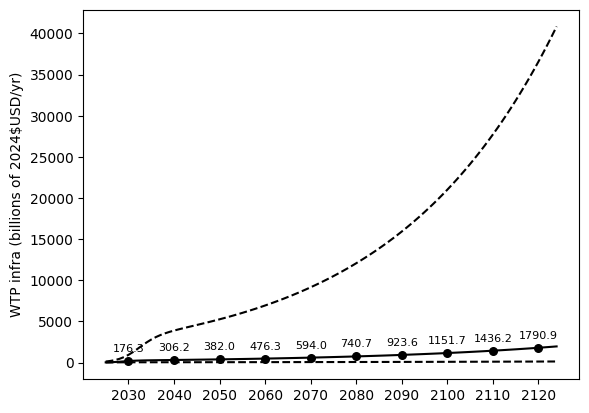

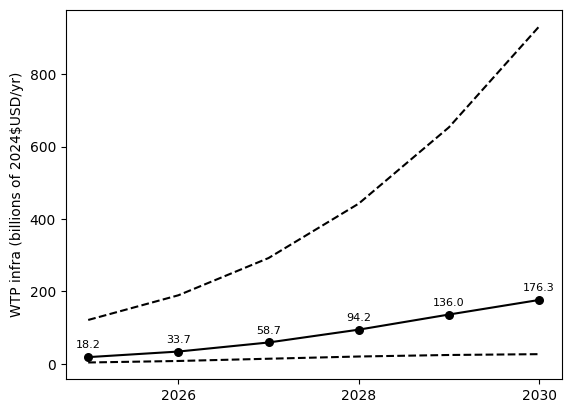



## Willingness to Pay Over Time (Largest single model) ##
Year: 2025 - willingness log 2024$USD per year for largest single model 8.9 (~728.6 million) 80% CI 8.5 (~344.6 million) - 9.2 (~1.5 billion)
Year: 2026 - willingness log 2024$USD per year for largest single model 9.1 (~1.3 billion) 80% CI 8.9 (~758.7 million) - 9.4 (~2.4 billion)
Year: 2027 - willingness log 2024$USD per year for largest single model 9.4 (~2.3 billion) 80% CI 9.1 (~1.4 billion) - 9.6 (~3.7 billion)
Year: 2028 - willingness log 2024$USD per year for largest single model 9.6 (~3.8 billion) 80% CI 9.3 (~2.0 billion) - 9.7 (~5.5 billion)
Year: 2029 - willingness log 2024$USD per year for largest single model 9.7 (~5.4 billion) 80% CI 9.4 (~2.4 billion) - 9.9 (~8.2 billion)
Year: 2030 - willingness log 2024$USD per year for largest single model 9.8 (~7.1 billion) 80% CI 9.4 (~2.6 billion) - 10.1 (~11.7 billion)
Year: 2031 - willingness log 2024$USD per year for largest single model 9.9 (~8.4 billion) 80% CI 9.4 (~

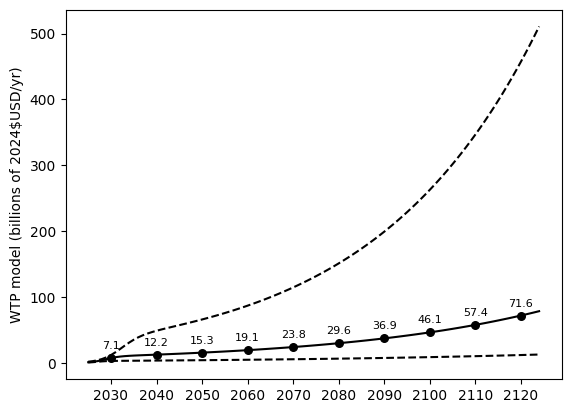

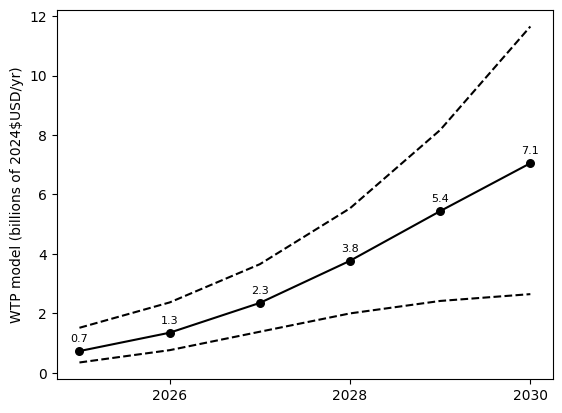



## Actual FLOP Needed to Make TAI (Given Algorithmic Progress) ##
Year: 2025 - logFLOP needed for TAI 31.3 (~20.0 nonillion) 80% CI 27.1 (~1.3 octillion) - 37.3 (~20.9 thousand decillion)
Year: 2026 - logFLOP needed for TAI 31.0 (~10.2 nonillion) 80% CI 26.8 (~660.7 septillion) - 37.1 (~12.9 thousand decillion)
Year: 2027 - logFLOP needed for TAI 30.7 (~5.2 nonillion) 80% CI 26.5 (~346.2 septillion) - 36.9 (~8.0 thousand decillion)
Year: 2028 - logFLOP needed for TAI 30.4 (~2.7 nonillion) 80% CI 26.3 (~184.4 septillion) - 36.7 (~4.9 thousand decillion)
Year: 2029 - logFLOP needed for TAI 30.2 (~1.4 nonillion) 80% CI 26.0 (~101.0 septillion) - 36.5 (~3.0 thousand decillion)
Year: 2030 - logFLOP needed for TAI 29.9 (~820.7 octillion) 80% CI 25.8 (~58.1 septillion) - 36.3 (~1.9 thousand decillion)
Year: 2031 - logFLOP needed for TAI 29.7 (~509.9 octillion) 80% CI 25.6 (~36.0 septillion) - 36.1 (~1.2 thousand decillion)
Year: 2032 - logFLOP needed for TAI 29.5 (~354.6 octillion) 80% CI 2

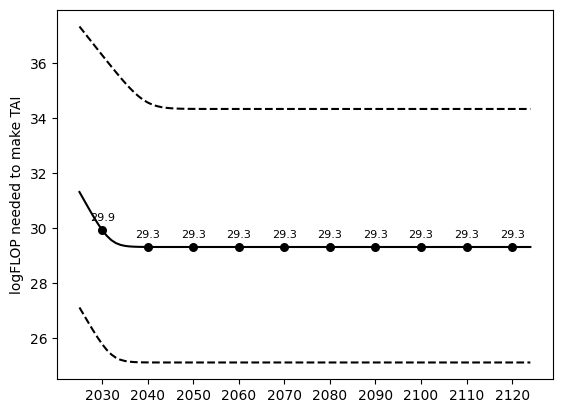

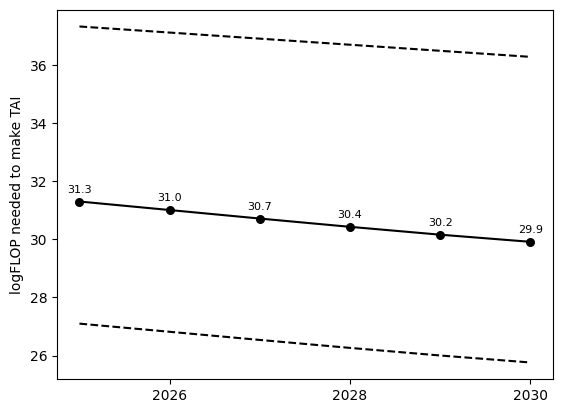



## FLOP per Dollar (Given Declining Costs) ##
Year: 2025 - logFLOP per 2024$1USD 18.3 (~2.1 quintillion) 80% CI 17.9 (~831.2 quadrillion) - 18.7 (~4.9 quintillion)
Year: 2026 - logFLOP per 2024$1USD 18.4 (~2.8 quintillion) 80% CI 18.1 (~1.1 quintillion) - 18.8 (~6.3 quintillion)
Year: 2027 - logFLOP per 2024$1USD 18.6 (~3.7 quintillion) 80% CI 18.2 (~1.5 quintillion) - 18.9 (~8.0 quintillion)
Year: 2028 - logFLOP per 2024$1USD 18.7 (~4.8 quintillion) 80% CI 18.3 (~2.1 quintillion) - 19.0 (~10.4 quintillion)
Year: 2029 - logFLOP per 2024$1USD 18.8 (~6.4 quintillion) 80% CI 18.5 (~2.9 quintillion) - 19.1 (~13.3 quintillion)
Year: 2030 - logFLOP per 2024$1USD 18.9 (~8.4 quintillion) 80% CI 18.6 (~3.9 quintillion) - 19.2 (~17.1 quintillion)
Year: 2031 - logFLOP per 2024$1USD 19.0 (~11.2 quintillion) 80% CI 18.7 (~5.3 quintillion) - 19.3 (~22.1 quintillion)
Year: 2032 - logFLOP per 2024$1USD 19.2 (~14.7 quintillion) 80% CI 18.9 (~7.2 quintillion) - 19.5 (~28.4 quintillion)
Year: 2033 - lo

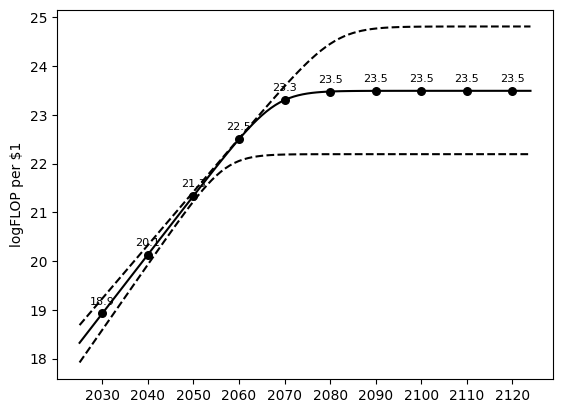

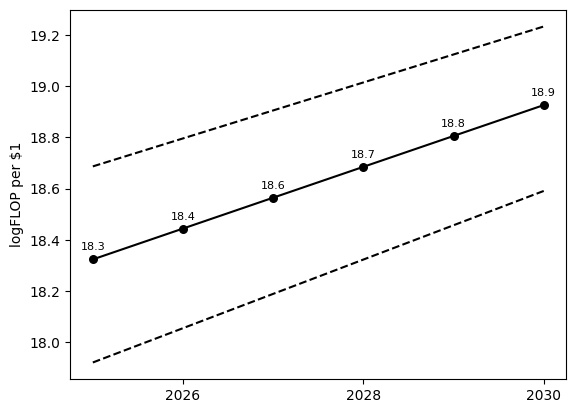



## Max Possible OOM Reduction in TAI FLOP Size ##
TAI log FLOP 20 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2

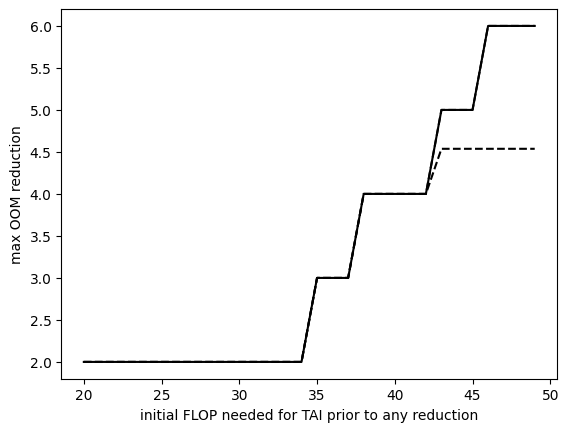



## Halving time (years) of compute requirements ##
TAI log FLOP 20 -> algo doubling rate 1.49yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 21 -> algo doubling rate 1.49yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 22 -> algo doubling rate 1.49yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 23 -> algo doubling rate 1.49yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 24 -> algo doubling rate 1.49yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 25 -> algo doubling rate 1.49yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 26 -> algo doubling rate 1.49yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 27 -> algo doubling rate 1.49yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 28 -> algo doubling rate 1.49yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 29 -> algo doubling rate 1.49yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 30 -> algo doubling rate 1.49yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 31 -> algo doubling rate 1.0yrs (80% CI: 1.63 to 1.63)
TAI log FLOP 32 -> algo doubling rate 1.0yrs (80% CI: 1.13 to 1.13)
TAI log FLOP 33 -> algo doubling rate 1.0yrs (80% CI

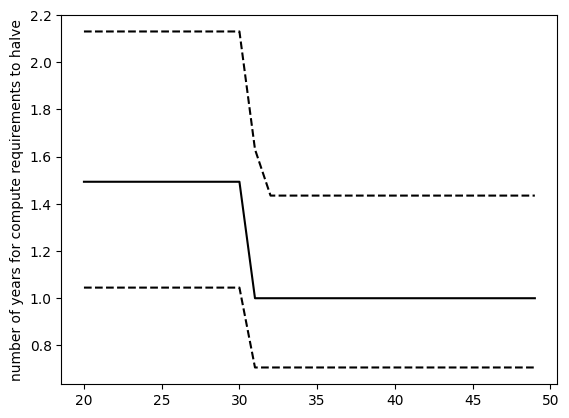



## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP) ##
Year: 2025 - 13.0 log 2024$USD to buy TAI (~9.5 trillion) 80% CI 9.2 (~1.5 billion) - 18.6 (~4.3 quintillion)
Year: 2026 - 12.6 log 2024$USD to buy TAI (~3.7 trillion) 80% CI 8.8 (~583.6 million) - 18.3 (~2.1 quintillion)
Year: 2027 - 12.1 log 2024$USD to buy TAI (~1.4 trillion) 80% CI 8.4 (~224.5 million) - 18.0 (~990.1 quadrillion)
Year: 2028 - 11.7 log 2024$USD to buy TAI (~555.0 billion) 80% CI 7.9 (~87.8 million) - 17.7 (~475.4 quadrillion)
Year: 2029 - 11.4 log 2024$USD to buy TAI (~225.6 billion) 80% CI 7.5 (~35.3 million) - 17.4 (~228.5 quadrillion)
Year: 2030 - 11.0 log 2024$USD to buy TAI (~97.2 billion) 80% CI 7.2 (~14.9 million) - 17.0 (~110.0 quadrillion)
Year: 2031 - 10.7 log 2024$USD to buy TAI (~45.7 billion) 80% CI 6.8 (~6.8 million) - 16.7 (~53.1 quadrillion)
Year: 2032 - 10.4 log 2024$USD to buy TAI (~24.1 billion) 80% CI 6.5 (~3.4 million) - 16.4 (~25.7 quadrillion)
Year: 203

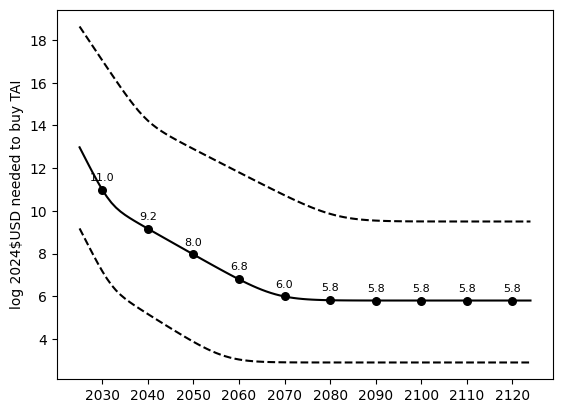

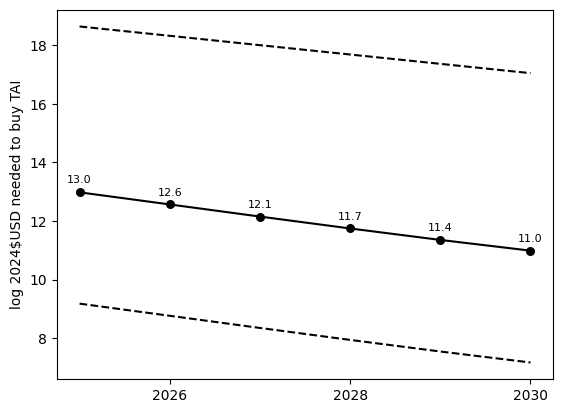



## Actual FLOP at Max Spend ##
Year: 2025 - max log FLOP 27.2 (~1.5 octillion) 80% CI 26.5 (~286.4 septillion) - 27.9 (~7.4 octillion)
Year: 2026 - max log FLOP 27.6 (~3.7 octillion) 80% CI 26.9 (~859.0 septillion) - 28.2 (~14.8 octillion)
Year: 2027 - max log FLOP 27.9 (~8.6 octillion) 80% CI 27.3 (~2.1 octillion) - 28.5 (~29.4 octillion)
Year: 2028 - max log FLOP 28.3 (~18.2 octillion) 80% CI 27.6 (~4.2 octillion) - 28.8 (~57.3 octillion)
Year: 2029 - max log FLOP 28.5 (~34.8 octillion) 80% CI 27.8 (~6.9 octillion) - 29.0 (~108.8 octillion)
Year: 2030 - max log FLOP 28.8 (~59.5 octillion) 80% CI 28.0 (~10.3 octillion) - 29.3 (~199.8 octillion)
Year: 2031 - max log FLOP 29.0 (~93.2 octillion) 80% CI 28.2 (~14.7 octillion) - 29.5 (~351.5 octillion)
Year: 2032 - max log FLOP 29.1 (~137.0 octillion) 80% CI 28.3 (~20.6 octillion) - 29.8 (~589.9 octillion)
Year: 2033 - max log FLOP 29.3 (~193.8 octillion) 80% CI 28.5 (~28.6 octillion) - 30.0 (~942.5 octillion)
Year: 2034 - max log FLOP 2

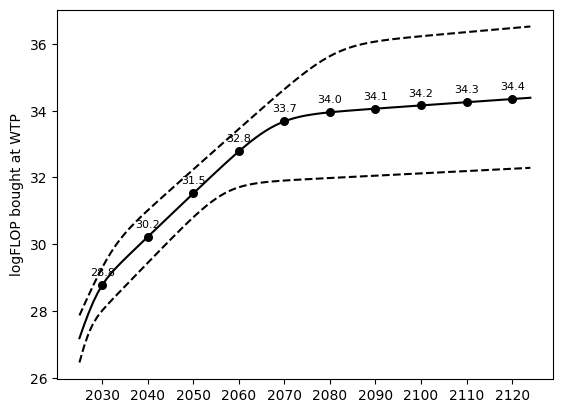

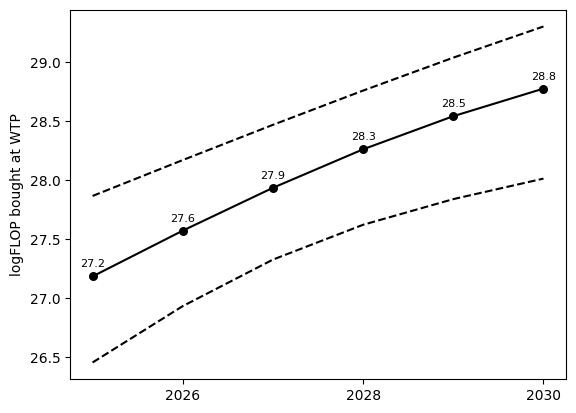



## Effective 2024-FLOP at Max Spend (given algorithmic progress and decline in $/FLOP) ##
Year: 2025 - max log effective 2024-FLOP 27.2 (~1.5 octillion) 80% CI 26.5 (~286.4 septillion) - 27.9 (~7.4 octillion)
Year: 2026 - max log effective 2024-FLOP 27.9 (~7.3 octillion) 80% CI 27.1 (~1.4 octillion) - 28.6 (~39.4 octillion)
Year: 2027 - max log effective 2024-FLOP 28.5 (~33.2 octillion) 80% CI 27.7 (~5.4 octillion) - 29.3 (~208.4 octillion)
Year: 2028 - max log effective 2024-FLOP 29.1 (~135.4 octillion) 80% CI 28.2 (~17.1 octillion) - 30.0 (~1.1 nonillion)
Year: 2029 - max log effective 2024-FLOP 29.7 (~480.9 octillion) 80% CI 28.6 (~44.7 octillion) - 30.7 (~5.3 nonillion)
Year: 2030 - max log effective 2024-FLOP 30.2 (~1.4 nonillion) 80% CI 29.0 (~103.8 octillion) - 31.4 (~24.0 nonillion)
Year: 2031 - max log effective 2024-FLOP 30.6 (~3.6 nonillion) 80% CI 29.4 (~225.9 octillion) - 32.0 (~93.9 nonillion)
Year: 2032 - max log effective 2024-FLOP 30.9 (~7.7 nonillion) 80% CI 29.7 (~

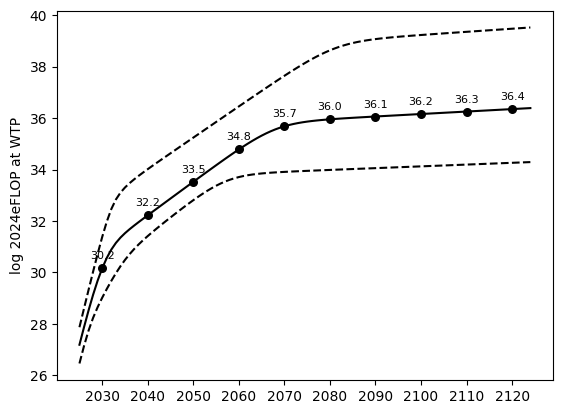

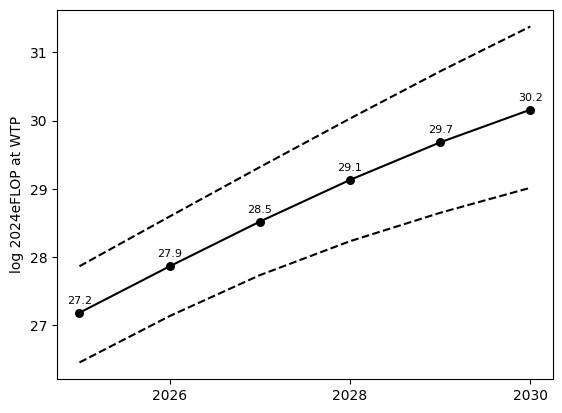


## TAI FLOP SIZE ##
{1: 24.6,
 5: 25.6,
 10: 26.2,
 20: 27.1,
 30: 28.0,
 40: 29.9,
 50: 31.3,
 60: 33.239999999999995,
 70: 35.1,
 80: 37.32,
 90: 40.6,
 95: 43.30999999999999,
 99: 49.601}


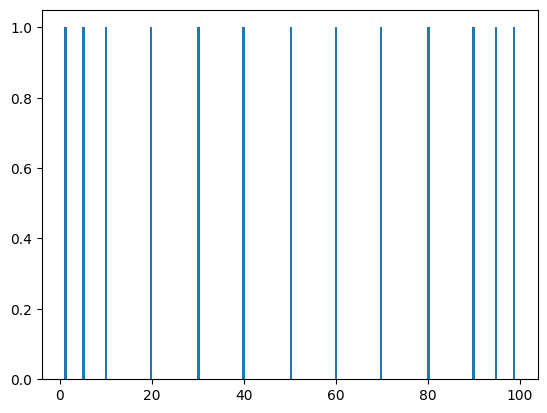



## MIN REDUCTION: 2 ##

## MAX REDUCTION ##
{1: 2.3761976795626008,
 5: 3.074327912604905,
 10: 3.711757589881393,
 20: 4.537154972854339,
 30: 5.307909606367253,
 40: 6.193791672743964,
 50: 6.956106317167671,
 60: 7.800699746152587,
 70: 8.734631205494628,
 80: 9.97742170780833,
 90: 12.105557001607027,
 95: 15.071259344127206,
 99: 22.031220750593185}


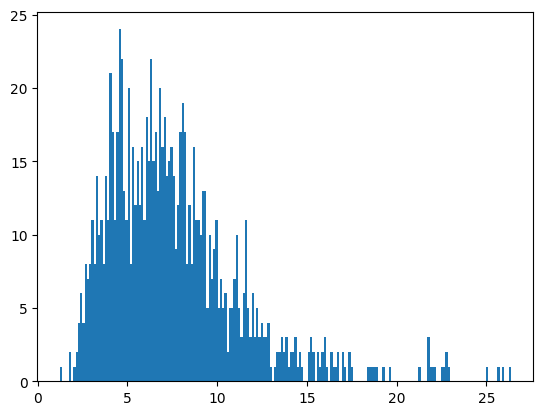



## MIN ALGO DOUBLING RATE ##
{1: 0.3679301017472495,
 5: 0.5004762240542081,
 10: 0.5882406042438952,
 20: 0.7051162666653972,
 30: 0.8033873169617335,
 40: 0.8888681625465524,
 50: 0.9989171977329738,
 60: 1.1175713325544514,
 70: 1.2686861306208486,
 80: 1.4343212060362183,
 90: 1.7281508684994955,
 95: 2.008296561340022,
 99: 2.5029536803018786}


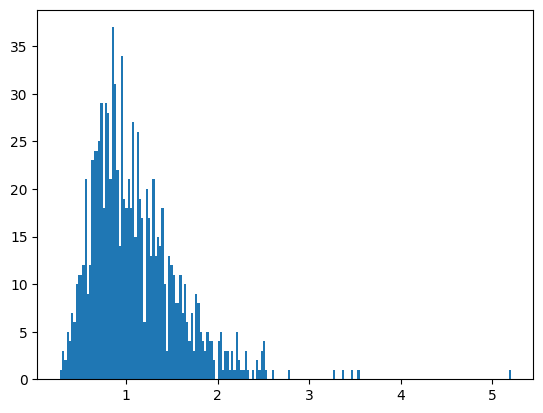



## MAX ALGO DOUBLING RATE ##
{1: 0.5570217958034351,
 5: 0.7579516378037607,
 10: 0.8867708908596131,
 20: 1.043949767478187,
 30: 1.1926877935998863,
 40: 1.3355929634622015,
 50: 1.4930110097426184,
 60: 1.6733679283728204,
 70: 1.8801410060119421,
 80: 2.1305778695243998,
 90: 2.5133474082839964,
 95: 2.839643148726906,
 99: 3.7721410682918024}


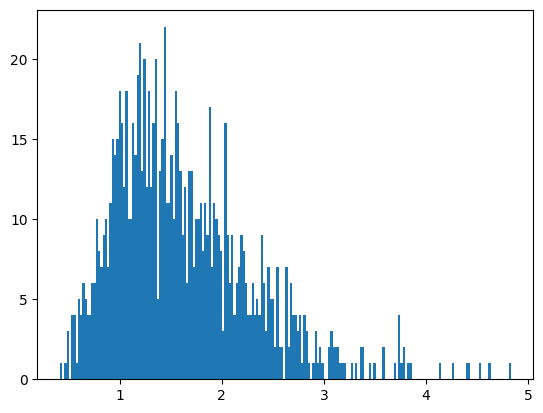



## INITIAL FLOP PER DOLLAR ##
{1: 17.185923933812802,
 5: 17.563529900526223,
 10: 17.7150012578262,
 20: 17.919730875080653,
 30: 18.053187630385544,
 40: 18.174140367478564,
 50: 18.322921017646987,
 60: 18.435686235415034,
 70: 18.552506923789245,
 80: 18.686753919985406,
 90: 18.951449733196448,
 95: 19.110299809324584,
 99: 19.445925553964475}


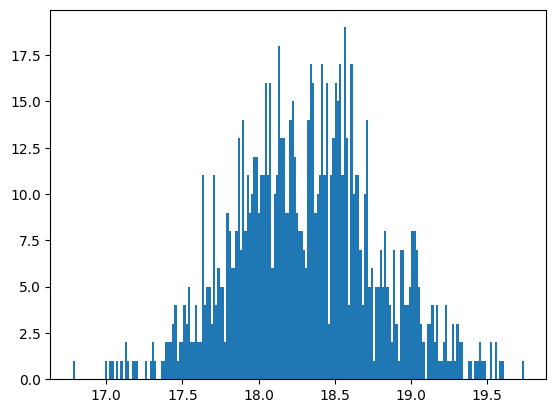



## FLOP HALVING RATE ##
{1: 1.7517477291892258,
 5: 1.9806664368952254,
 10: 2.1086958644438587,
 20: 2.242866296734383,
 30: 2.34296149553158,
 40: 2.4157634010522906,
 50: 2.49340958525393,
 60: 2.5725063219285564,
 70: 2.6533140467212144,
 80: 2.749847628705224,
 90: 2.899763417296154,
 95: 3.0137757009813466,
 99: 3.2120903212624774}


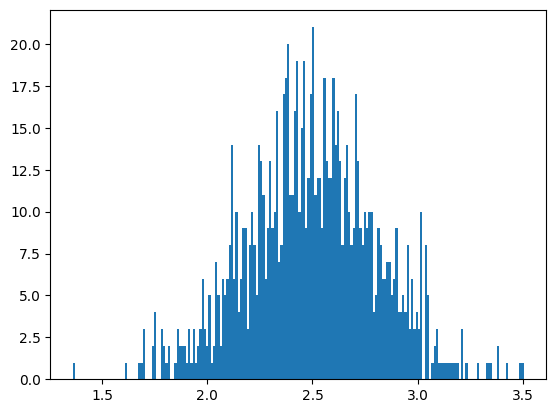



## MAX FLOP PER DOLLAR ##
{1: 19.992291894534144,
 5: 21.039989811262622,
 10: 21.603527398770655,
 20: 22.194949206400594,
 30: 22.619224381803193,
 40: 23.09403562997689,
 50: 23.495154945728665,
 60: 23.834368185380654,
 70: 24.251944583006008,
 80: 24.815705159619686,
 90: 25.48177303956404,
 95: 26.09717576578431,
 99: 26.974867375436823}


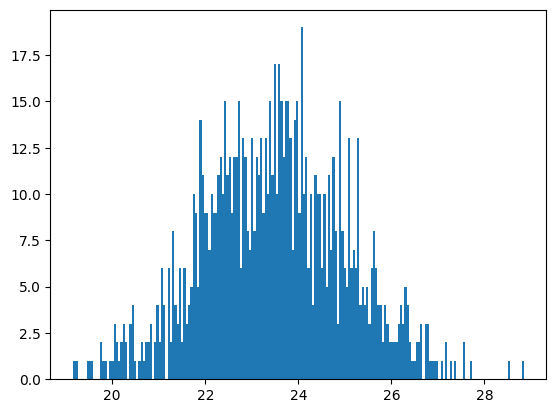



## INITIAL PAY ##
{1: 8.1,
 5: 8.3,
 10: 8.4,
 20: 8.6,
 30: 8.7,
 40: 8.8,
 50: 8.9,
 60: 9.0,
 70: 9.1,
 80: 9.2,
 90: 9.5,
 95: 9.7,
 99: 10.1}


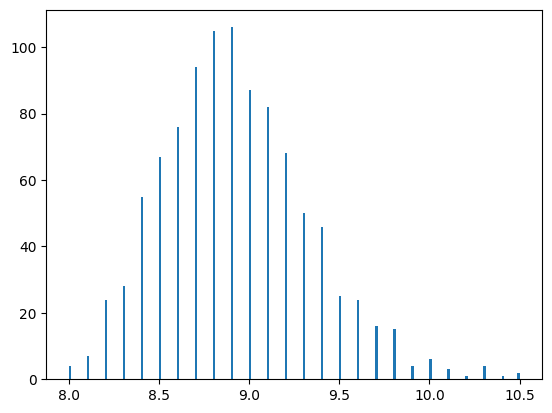



## INITIAL GDP ##
{1: 24819198537441.375,
 5: 24899040322146.664,
 10: 24948850516209.645,
 20: 25007492434167.38,
 30: 25044985968760.945,
 40: 25079328172996.434,
 50: 25110318601275.188,
 60: 25144558111062.645,
 70: 25169353041686.37,
 80: 25204680824439.336,
 90: 25268918386479.465,
 95: 25324691084469.973,
 99: 25408770797808.82}


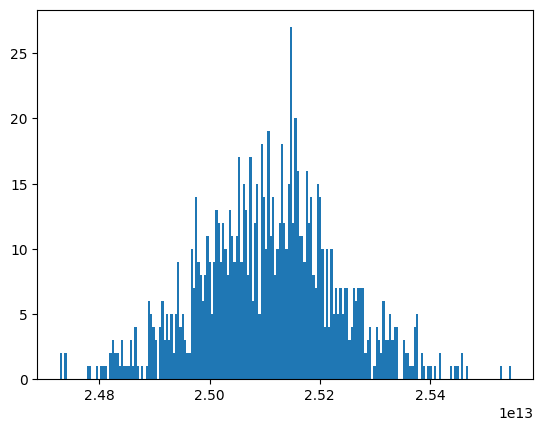



## GDP GROWTH ##
{1: 1.005,
 5: 1.009283265399058,
 10: 1.0125698197754984,
 20: 1.0160618758041167,
 30: 1.0183669958506332,
 40: 1.0203689400066245,
 50: 1.0223185679309044,
 60: 1.024235615587927,
 70: 1.0260061198839021,
 80: 1.0281031874590083,
 90: 1.0316259977560664,
 95: 1.034389202046198,
 99: 1.03793182678517}


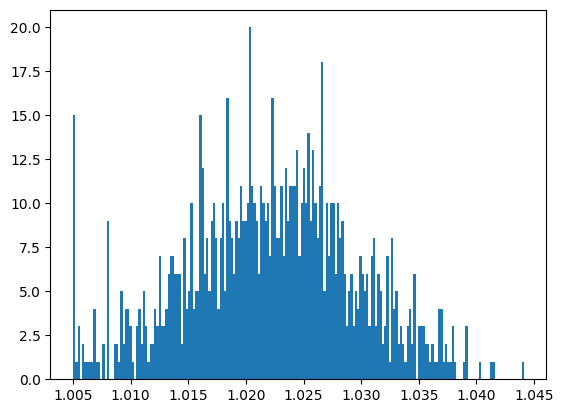



## MAX GDP FRAC ##
{1: 1.2174714255192826e-05,
 5: 3.2653321778964064e-05,
 10: 5.826137933215633e-05,
 20: 0.00010249960258915334,
 30: 0.0001542046979025668,
 40: 0.0002477602850308439,
 50: 0.0003504148842328957,
 60: 0.0005388216161897034,
 70: 0.0007870452361898605,
 80: 0.0013032397545572727,
 90: 0.002642502340709036,
 95: 0.004284160244869935,
 99: 0.011862240873067661}


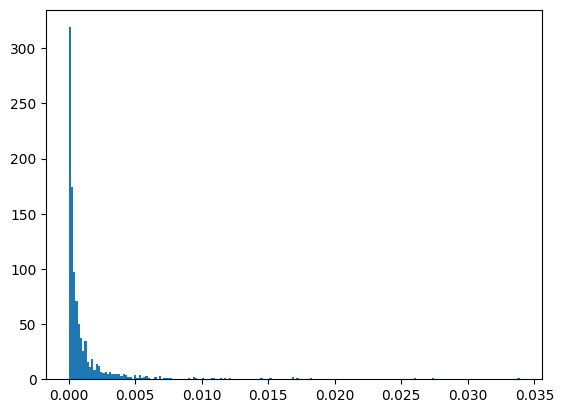



## SPEND DOUBLING TIME ##
{1: 0.40060210755705994,
 5: 0.5081629812462689,
 10: 0.5801373383667826,
 20: 0.7006659628732751,
 30: 0.7995505129391388,
 40: 0.9081594611875945,
 50: 1.005251424578958,
 60: 1.1181355007063136,
 70: 1.2597052621152387,
 80: 1.4658704063791184,
 90: 1.7559378947540991,
 95: 1.9797413975918197,
 99: 2.6940182072810384}


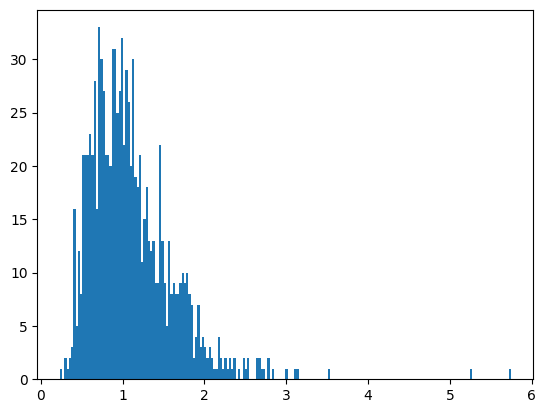





## Nonscaling delay ##
There are 3 ways a non-scaling delay could happen.
- algorithms: additional <Distribution> mixture
 - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
 - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) years if it happens
{1: 1,
 5: 1,
 10: 1,
 20: 2,
 30: 2,
 40: 2,
 50: 2,
 60: 3,
 70: 3,
 80: 4,
 90: 5,
 95: 7,
 99: 15}
## Chance of nonscaling delay ##


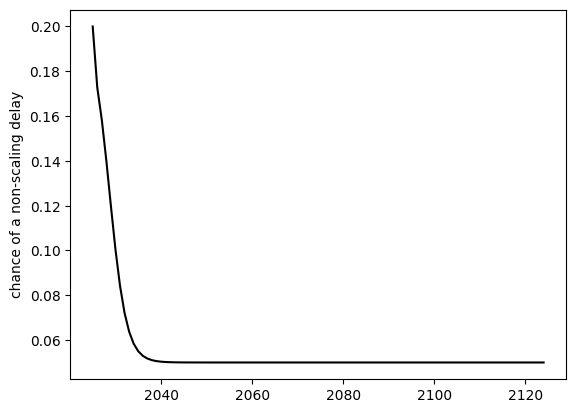

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2035 - c

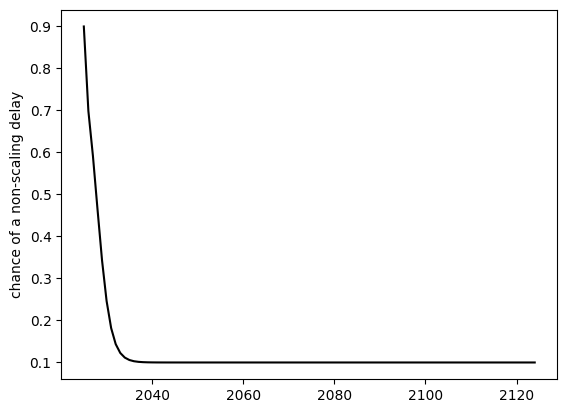

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 59%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 47%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 34%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2035

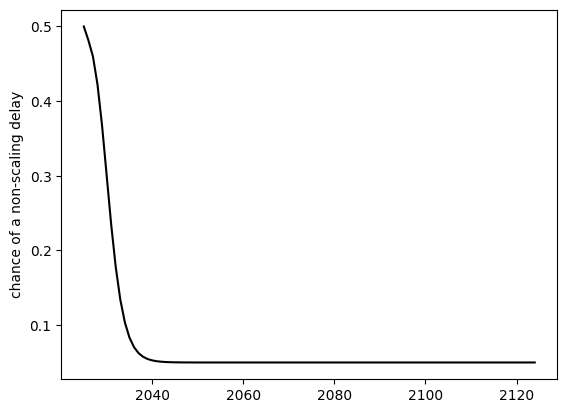

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 48%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 46%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 42%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2035

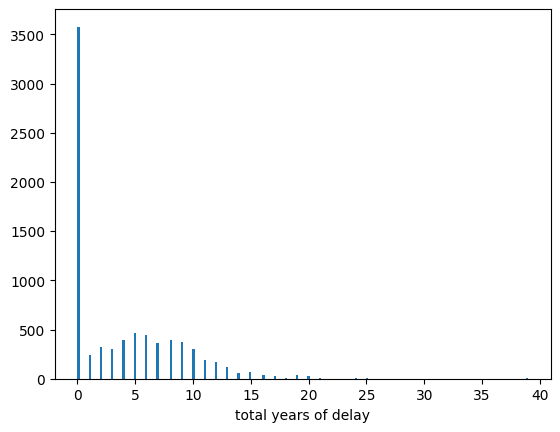

In [15]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=max(1, os.cpu_count() - 2),
                    runs=variables['RUNS'],
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##

In this simulation:
* It takes 36.1 log FLOP (~1.3 thousand decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.0 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~329.3 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~747.4 million).
* This doubles every 1.3 year to a max of 0.050989% of GDP (initially ~12.7 billion 2025$USD).
* GDP grows at a rate of 1.005x per year.
---
2025 - TAI takes 36.1 logFLOP which costs 18.1 log 2025$USD to buy vs. WTP at 8.8 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 35.7 logFLOP which costs 17.6 log 2025$USD to buy vs. WTP at 9.1 (buys 27.2 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 35.4 logFLOP which costs 17.1 log 2025$USD to buy vs. WTP at 9.3 (buys 27.5 log FLOP or 28.3 2025-log-eFLOP)
2028 - TAI takes 35.0 logFLOP wh

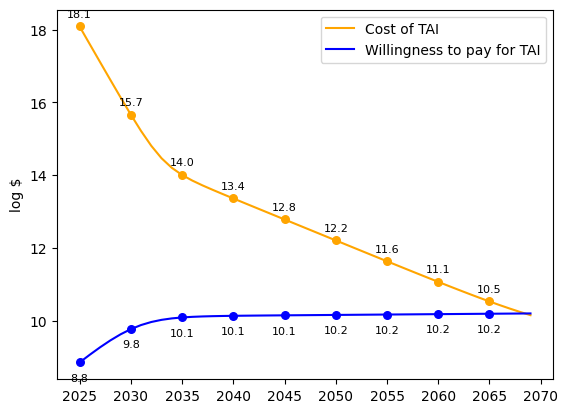

-
-
## SAMPLE RUN 5 ##

In this simulation:
* It takes 36.1 log FLOP (~1.3 thousand decillion) for transformative capabilities.
* Every 2.2 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.2 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 28.2 log FLOP (~14.7 octillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.4 billion).
* This doubles every 1.0 year to a max of 0.010067% of GDP (initially ~2.5 billion 2025$USD).
* GDP grows at a rate of 1.034x per year.
---
2025 - TAI takes 36.1 logFLOP which costs 17.3 log 2025$USD to buy vs. WTP at 9.0 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 36.0 logFLOP which costs 17.1 log 2025$USD to buy vs. WTP at 9.1 (buys 28.0 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 35.8 logFLOP which costs 16.8 log 2025$USD to buy vs. WTP at 9.2 (buys 28.2 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 35.7 logFLOP which c

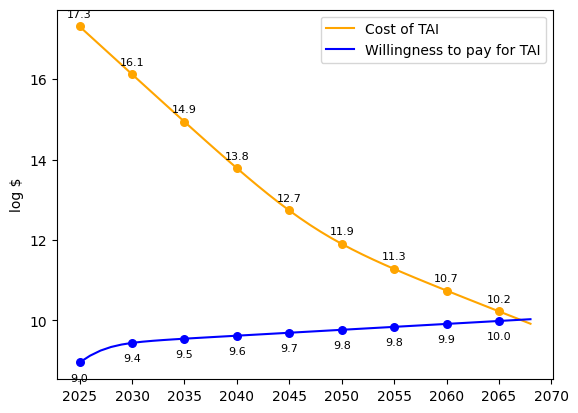

-
-
## SAMPLE RUN 6 ##

In this simulation:
* It takes 31.8 log FLOP (~63.1 nonillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.2 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~42.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~463.6 million).
* This doubles every 1.8 year to a max of 0.024508% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 31.8 logFLOP which costs 13.7 log 2025$USD to buy vs. WTP at 8.6 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
2026 - TAI takes 31.5 logFLOP which costs 13.3 log 2025$USD to buy vs. WTP at 8.8 (buys 27.0 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 31.1 logFLOP which costs 12.8 log 2025$USD to buy vs. WTP at 8.9 (buys 27.3 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 30.8 logFLOP which costs 

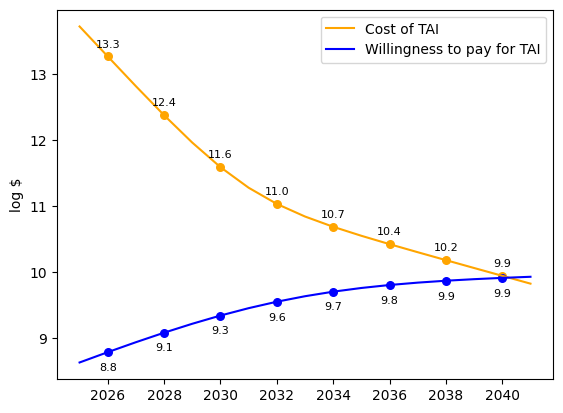

-
-
## SAMPLE RUN 7 ##

In this simulation:
* It takes 27.2 log FLOP (~1.6 octillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~482.2 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~85.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~308.5 million).
* This doubles every 1.3 year to a max of 0.050474% of GDP (initially ~12.7 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 27.2 logFLOP which costs 9.5 log 2025$USD to buy vs. WTP at 8.5 (buys 26.2 log FLOP or 26.2 2025-log-eFLOP)
2026 - TAI takes 27.0 logFLOP which costs 9.2 log 2025$USD to buy vs. WTP at 8.7 (buys 26.5 log FLOP or 26.7 2025-log-eFLOP)
2027 - TAI takes 26.7 logFLOP which costs 8.8 log 2025$USD to buy vs. WTP at 8.9 (buys 26.8 log FLOP or 27.3 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1583 -

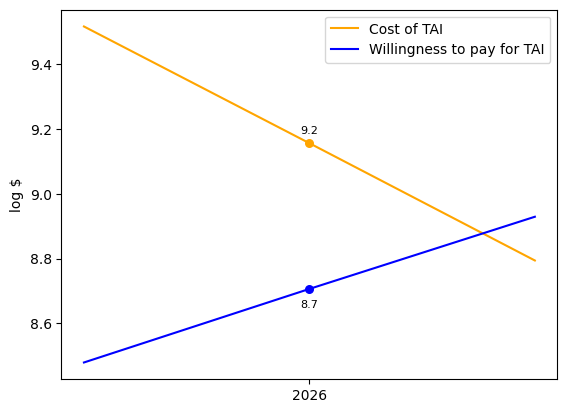

-
-
## SAMPLE RUN 8 ##

In this simulation:
* It takes 34.2 log FLOP (~15.8 decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.8 quintillion) per 2025$USD.
* Every 3.1 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~24.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~499.7 million).
* This doubles every 1.2 year to a max of 0.665846% of GDP (initially ~168.0 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 34.2 logFLOP which costs 15.8 log 2025$USD to buy vs. WTP at 8.7 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 33.9 logFLOP which costs 15.3 log 2025$USD to buy vs. WTP at 8.9 (buys 27.5 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 33.5 logFLOP which costs 14.9 log 2025$USD to buy vs. WTP at 9.2 (buys 27.8 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 33.2 logFLOP which cost

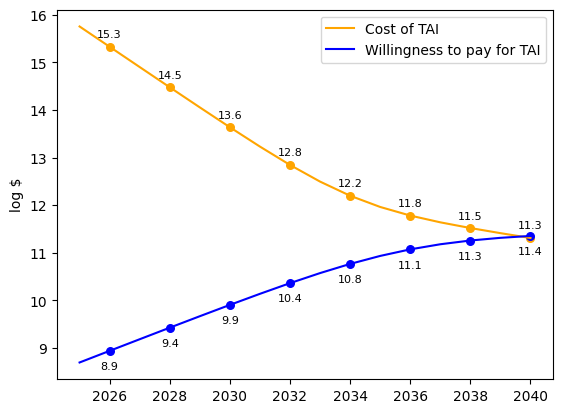

-
-
## SAMPLE RUN 9 ##

In this simulation:
* It takes 29.3 log FLOP (~199.5 octillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.4 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~380.2 million).
* This doubles every 0.9 year to a max of 0.033487% of GDP (initially ~8.4 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 29.3 logFLOP which costs 10.7 log 2025$USD to buy vs. WTP at 8.6 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 29.1 logFLOP which costs 10.3 log 2025$USD to buy vs. WTP at 8.9 (buys 27.6 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 28.8 logFLOP which costs 10.0 log 2025$USD to buy vs. WTP at 9.2 (buys 28.1 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 28.6 logFLOP which costs 

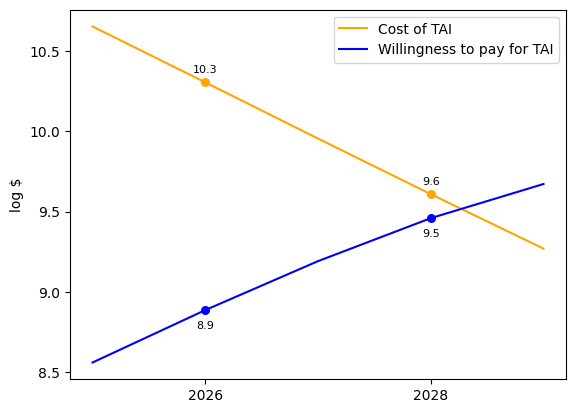

-
-
## SAMPLE RUN 10 ##

In this simulation:
* It takes 39.5 log FLOP (~3.2 million decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~10.4 quintillion) per 2025$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~11.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~711.5 million).
* This doubles every 0.9 year to a max of 0.027194% of GDP (initially ~6.8 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 39.5 logFLOP which costs 20.5 log 2025$USD to buy vs. WTP at 8.8 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 39.2 logFLOP which costs 20.0 log 2025$USD to buy vs. WTP at 9.1 (buys 28.2 log FLOP or 28.6 2025-log-eFLOP)
2027 - TAI takes 38.8 logFLOP which costs 19.6 log 2025$USD to buy vs. WTP at 9.4 (buys 28.6 log FLOP or 29.3 2025-log-eFLOP)
2028 - TAI takes 38.5 logFLOP whi

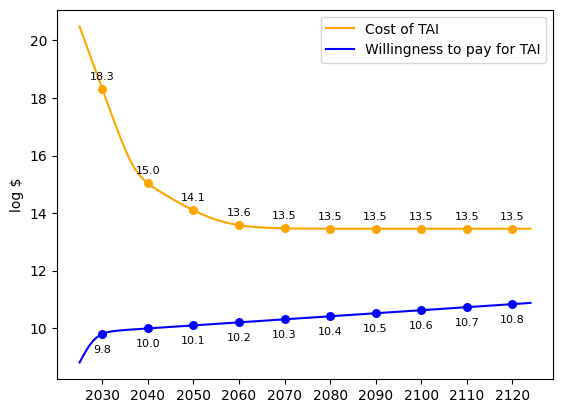

-
-
## SAMPLE RUN 11 ##

In this simulation:
* It takes 27.3 log FLOP (~2.0 octillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.3 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~20.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~776.4 million).
* This doubles every 0.9 year to a max of 0.00612% of GDP (initially ~1.5 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 27.3 logFLOP which costs 8.5 log 2025$USD to buy vs. WTP at 8.7 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 6 more

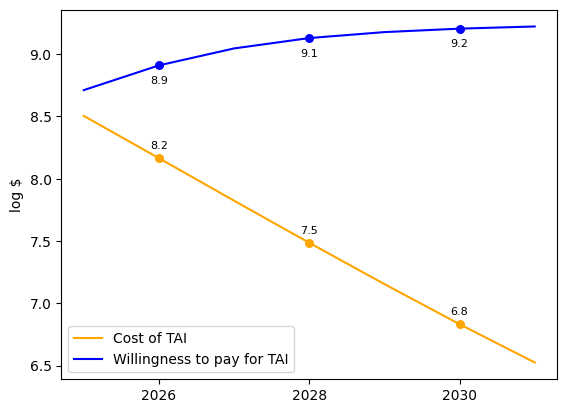

-
-
## SAMPLE RUN 12 ##

In this simulation:
* It takes 36.2 log FLOP (~1.6 thousand decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~920.6 quadrillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.1 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~770.1 million).
* This doubles every 0.8 year to a max of 0.099172% of GDP (initially ~25.2 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 36.2 logFLOP which costs 18.2 log 2025$USD to buy vs. WTP at 8.9 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 36.0 logFLOP which costs 17.9 log 2025$USD to buy vs. WTP at 9.3 (buys 27.3 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 35.8 logFLOP which costs 17.6 log 2025$USD to buy vs. WTP at 9.6 (buys 27.8 log FLOP or 28.3 2025-log-eFLOP)
2028 - TAI takes 35.6 logFLOP w

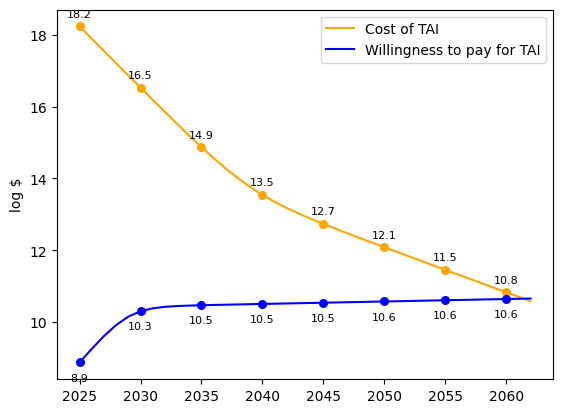

-
-
## SAMPLE RUN 13 ##

In this simulation:
* It takes 27.6 log FLOP (~4.0 octillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.1 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~178.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~426.1 million).
* This doubles every 1.5 year to a max of 0.011265% of GDP (initially ~2.8 billion 2025$USD).
* GDP grows at a rate of 1.034x per year.
---
2025 - TAI takes 27.6 logFLOP which costs 9.0 log 2025$USD to buy vs. WTP at 8.6 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 27.3 logFLOP which costs 8.6 log 2025$USD to buy vs. WTP at 8.7 (buys 27.5 log FLOP or 27.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6988 -> Nonscaling delay occured
-- -- this delay is 19 years

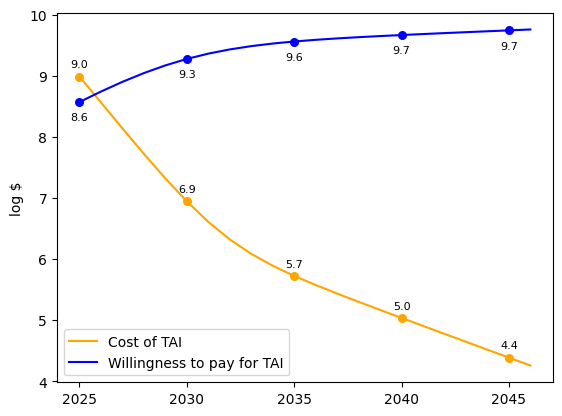

-
-
## SAMPLE RUN 14 ##

In this simulation:
* It takes 33.1 log FLOP (~1.3 decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.1 quintillion) per 2025$USD.
* Every 3.4 years they get 2x cheaper, to a maximum of 25.7 log FLOP (~45.7 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.0 billion).
* This doubles every 0.7 year to a max of 0.021347% of GDP (initially ~5.4 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 33.1 logFLOP which costs 14.8 log 2025$USD to buy vs. WTP at 8.9 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 32.7 logFLOP which costs 14.3 log 2025$USD to buy vs. WTP at 9.3 (buys 27.7 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 32.3 logFLOP which costs 13.8 log 2025$USD to buy vs. WTP at 9.5 (buys 28.0 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 31.9 logFLOP which costs 13

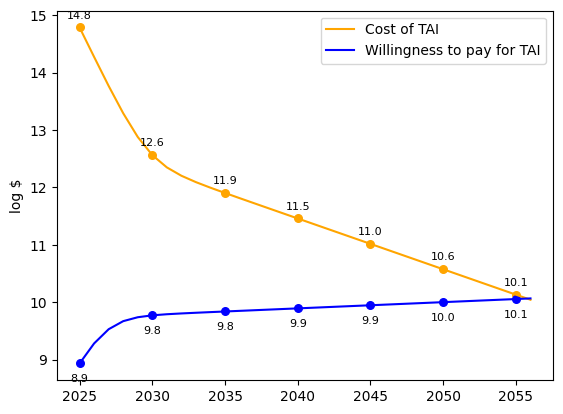

-
-
## SAMPLE RUN 15 ##

In this simulation:
* It takes 34.8 log FLOP (~63.1 decillion) for transformative capabilities.
* Every 2.6 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~5.7 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 25.6 log FLOP (~38.2 septillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.5 billion).
* This doubles every 2.1 year to a max of 0.016471% of GDP (initially ~4.1 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 34.8 logFLOP which costs 16.0 log 2025$USD to buy vs. WTP at 9.2 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 34.7 logFLOP which costs 15.8 log 2025$USD to buy vs. WTP at 9.3 (buys 28.1 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 34.6 logFLOP which costs 15.6 log 2025$USD to buy vs. WTP at 9.4 (buys 28.3 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 34.5 logFLOP which costs 1

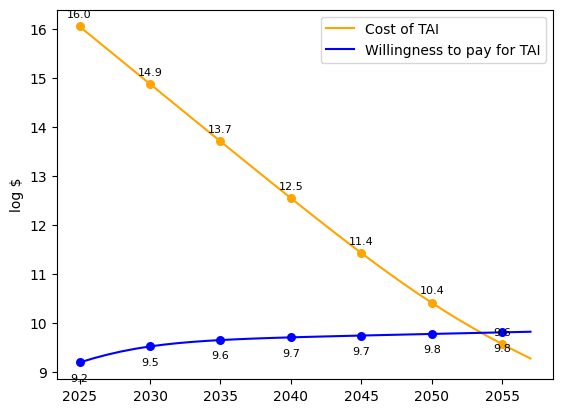

-
-
## SAMPLE RUN 16 ##

In this simulation:
* It takes 28.0 log FLOP (~10.0 octillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.3 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~1.9 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~768.2 million).
* This doubles every 2.4 year to a max of 0.092719% of GDP (initially ~23.3 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 28.0 logFLOP which costs 9.5 log 2025$USD to buy vs. WTP at 8.9 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 27.8 logFLOP which costs 9.2 log 2025$USD to buy vs. WTP at 9.0 (buys 27.6 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 27.6 logFLOP which costs 8.8 log 2025$USD to buy vs. WTP at 9.1 (buys 27.9 log FLOP or 28.3 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1583 -> 

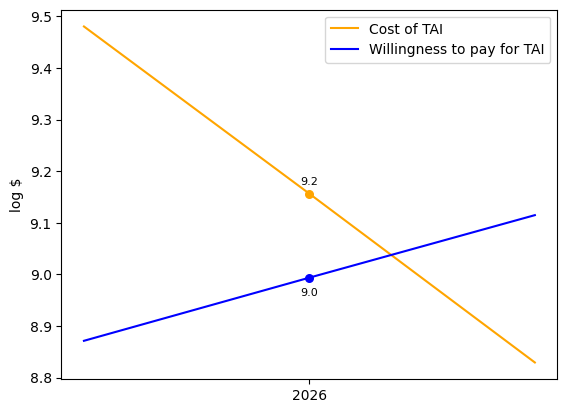

-
-
## SAMPLE RUN 17 ##

In this simulation:
* It takes 24.5 log FLOP (~3.2 septillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~457.7 quadrillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 25.3 log FLOP (~20.0 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~852.1 million).
* This doubles every 1.5 year to a max of 0.010511% of GDP (initially ~2.6 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 24.5 logFLOP which costs 6.8 log 2025$USD to buy vs. WTP at 8.8 (buys 26.5 log FLOP or 26.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 7 

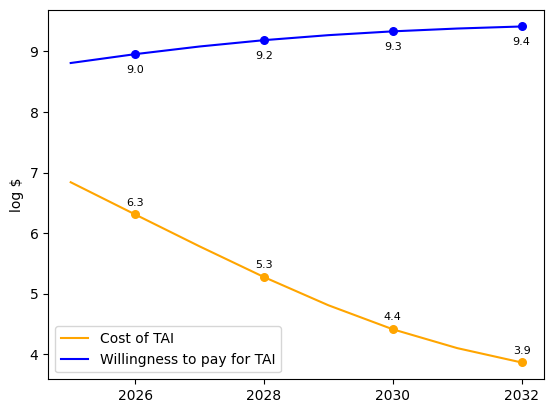

-
-
## SAMPLE RUN 18 ##

In this simulation:
* It takes 45.8 log FLOP (~6.3 trillion decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.3 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 19.4 log FLOP (~25.8 quintillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~313.0 million).
* This doubles every 1.1 year to a max of 0.121473% of GDP (initially ~30.3 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 45.8 logFLOP which costs 27.7 log 2025$USD to buy vs. WTP at 8.5 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 45.4 logFLOP which costs 27.2 log 2025$USD to buy vs. WTP at 8.8 (buys 27.0 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 45.0 logFLOP which costs 26.7 log 2025$USD to buy vs. WTP at 9.0 (buys 27.3 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 44.6 logFLOP wh

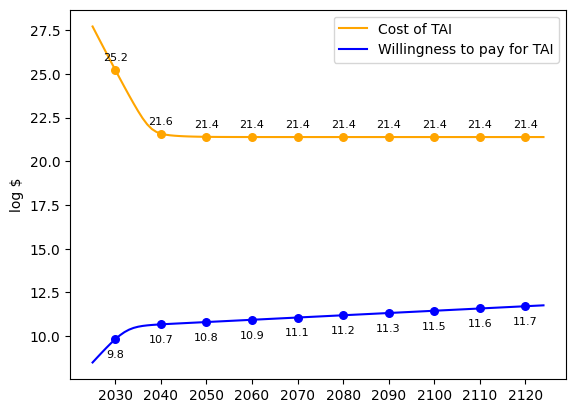

-
-
## SAMPLE RUN 19 ##

In this simulation:
* It takes 32.4 log FLOP (~251.2 nonillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.8 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~59.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~979.6 million).
* This doubles every 1.2 year to a max of 0.190966% of GDP (initially ~48.1 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 32.4 logFLOP which costs 13.5 log 2025$USD to buy vs. WTP at 9.0 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 32.2 logFLOP which costs 13.1 log 2025$USD to buy vs. WTP at 9.2 (buys 28.3 log FLOP or 28.5 2025-log-eFLOP)
2027 - TAI takes 32.0 logFLOP which costs 12.8 log 2025$USD to buy vs. WTP at 9.5 (buys 28.7 log FLOP or 29.1 2025-log-eFLOP)
2028 - TAI takes 31.7 logFLOP which cos

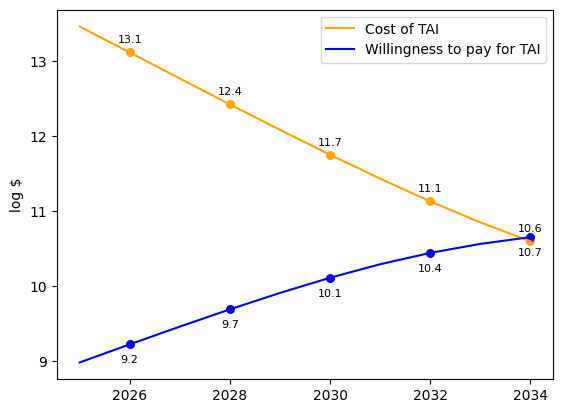

-
-
## SAMPLE RUN 20 ##

In this simulation:
* It takes 50.0 log FLOP (~100.0 quadrillion decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 5.2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.1 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~4.8 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~590.1 million).
* This doubles every 0.4 year to a max of 0.036476% of GDP (initially ~9.1 billion 2025$USD).
* GDP grows at a rate of 1.037x per year.
---
2025 - TAI takes 50.0 logFLOP which costs 31.1 log 2025$USD to buy vs. WTP at 8.7 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 49.8 logFLOP which costs 30.7 log 2025$USD to buy vs. WTP at 9.4 (buys 28.4 log FLOP or 28.7 2025-log-eFLOP)
2027 - TAI takes 49.5 logFLOP which costs 30.3 log 2025$USD to buy vs. WTP at 9.8 (buys 29.0 log FLOP or 29.5 2025-log-eFLOP)
2028 - TAI takes 49.3 logFL

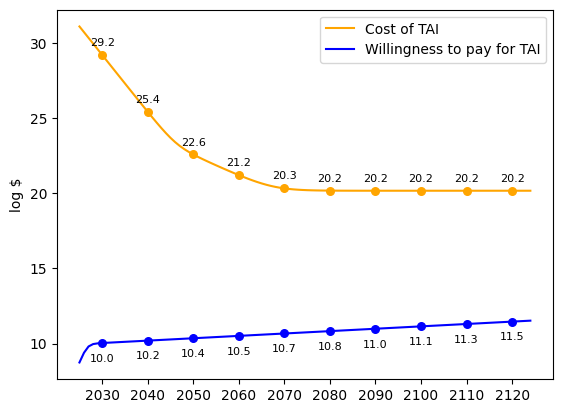

-
-
## SAMPLE RUN 21 ##

In this simulation:
* It takes 31.9 log FLOP (~79.4 nonillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~11.8 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 20.6 log FLOP (~363.6 quintillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~777.1 million).
* This doubles every 1.4 year to a max of 0.140574% of GDP (initially ~35.8 billion 2025$USD).
* GDP grows at a rate of 1.01x per year.
---
2025 - TAI takes 31.9 logFLOP which costs 12.8 log 2025$USD to buy vs. WTP at 8.9 (buys 27.9 log FLOP or 28.0 2025-log-eFLOP)
2026 - TAI takes 31.7 logFLOP which costs 12.6 log 2025$USD to buy vs. WTP at 9.1 (buys 28.3 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 31.6 logFLOP which costs 12.3 log 2025$USD to buy vs. WTP at 9.3 (buys 28.6 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 31.4 logFLOP which co

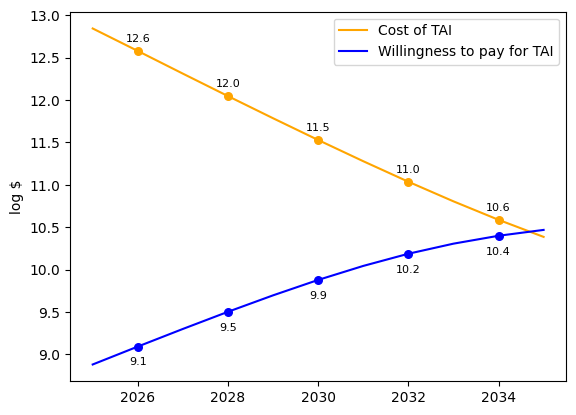

-
-
## SAMPLE RUN 22 ##

In this simulation:
* It takes 45.4 log FLOP (~2.5 trillion decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~16.5 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~11.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~949.8 million).
* This doubles every 0.8 year to a max of 0.074963% of GDP (initially ~18.9 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 45.4 logFLOP which costs 26.2 log 2025$USD to buy vs. WTP at 9.0 (buys 28.2 log FLOP or 28.2 2025-log-eFLOP)
2026 - TAI takes 45.1 logFLOP which costs 25.8 log 2025$USD to buy vs. WTP at 9.3 (buys 28.6 log FLOP or 28.9 2025-log-eFLOP)
2027 - TAI takes 44.8 logFLOP which costs 25.4 log 2025$USD to buy vs. WTP at 9.6 (buys 29.1 log FLOP or 29.6 2025-log-eFLOP)
2028 - TAI takes 44.5 logFLOP w

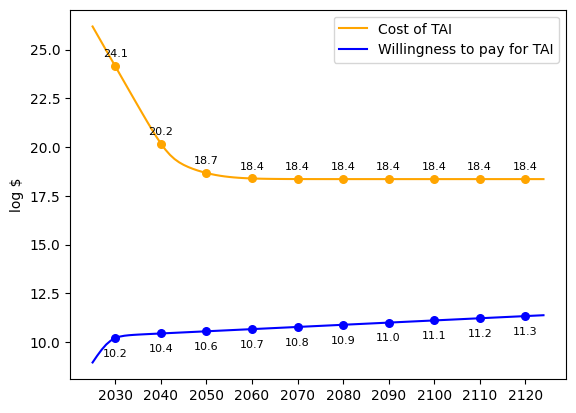

-
-
## SAMPLE RUN 23 ##

In this simulation:
* It takes 33.2 log FLOP (~1.6 decillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~2.9 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~52.8 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.1 billion).
* This doubles every 0.7 year to a max of 0.014396% of GDP (initially ~3.6 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 33.2 logFLOP which costs 14.7 log 2025$USD to buy vs. WTP at 8.9 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 32.7 logFLOP which costs 14.1 log 2025$USD to buy vs. WTP at 9.2 (buys 27.8 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 32.1 logFLOP which costs 13.4 log 2025$USD to buy vs. WTP at 9.4 (buys 28.1 log FLOP or 29.2 2025-log-eFLOP)
2028 - TAI takes 31.7 logFLOP which costs 12

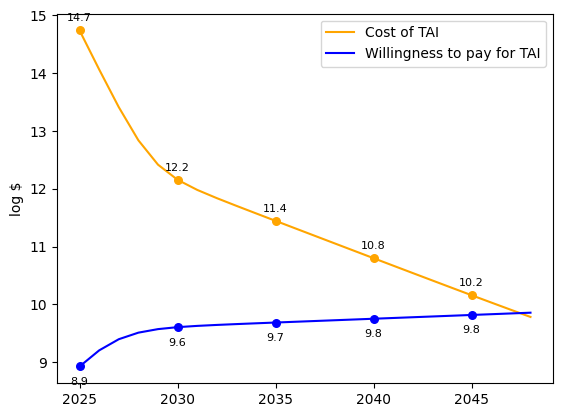

-
-
## SAMPLE RUN 24 ##

In this simulation:
* It takes 36.6 log FLOP (~4.0 thousand decillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~465.4 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~56.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~510.5 million).
* This doubles every 1.5 year to a max of 0.002259% of GDP (initially ~568.4 million 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 36.6 logFLOP which costs 18.9 log 2025$USD to buy vs. WTP at 8.4 (buys 26.1 log FLOP or 26.1 2025-log-eFLOP)
2026 - TAI takes 36.4 logFLOP which costs 18.6 log 2025$USD to buy vs. WTP at 8.5 (buys 26.3 log FLOP or 26.5 2025-log-eFLOP)
2027 - TAI takes 36.2 logFLOP which costs 18.3 log 2025$USD to buy vs. WTP at 8.6 (buys 26.5 log FLOP or 26.9 2025-log-eFLOP)
2028 - TAI takes 36.0 logFLOP

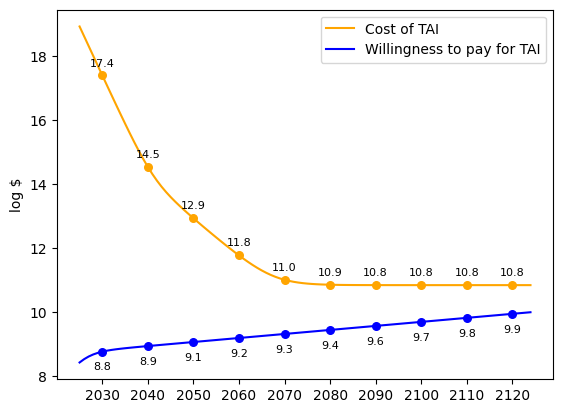

-
-
## SAMPLE RUN 25 ##

In this simulation:
* It takes 26.3 log FLOP (~199.5 septillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.6 log FLOP (~426.2 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~114.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~304.4 million).
* This doubles every 0.7 year to a max of 0.032422% of GDP (initially ~8.2 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 26.3 logFLOP which costs 8.7 log 2025$USD to buy vs. WTP at 8.5 (buys 26.1 log FLOP or 26.1 2025-log-eFLOP)
2026 - TAI takes 26.1 logFLOP which costs 8.4 log 2025$USD to buy vs. WTP at 8.9 (buys 26.6 log FLOP or 26.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6988 -> Nonscaling issue did not occur
-- data p_nonscal

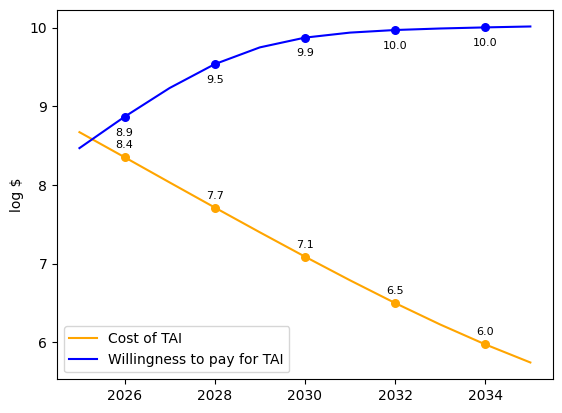

-
-
## SAMPLE RUN 26 ##

In this simulation:
* It takes 26.4 log FLOP (~251.2 septillion) for transformative capabilities.
* Every 1.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.2 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~43.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~305.2 million).
* This doubles every 1.0 year to a max of 0.001742% of GDP (initially ~439.3 million 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 26.4 logFLOP which costs 7.9 log 2025$USD to buy vs. WTP at 8.3 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 9 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not 

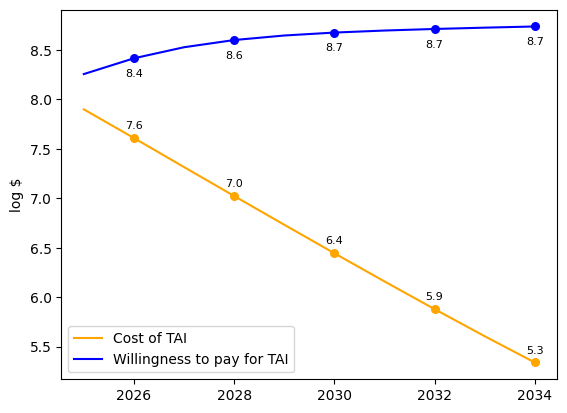

-
-
## SAMPLE RUN 27 ##

In this simulation:
* It takes 43.5 log FLOP (~31.6 billion decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 4.7 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.9 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~43.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~366.9 million).
* This doubles every 1.0 year to a max of 0.018596% of GDP (initially ~4.7 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 43.5 logFLOP which costs 24.6 log 2025$USD to buy vs. WTP at 8.5 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 43.2 logFLOP which costs 24.1 log 2025$USD to buy vs. WTP at 8.8 (buys 27.9 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 42.8 logFLOP which costs 23.6 log 2025$USD to buy vs. WTP at 9.0 (buys 28.3 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 42.5 logFLOP w

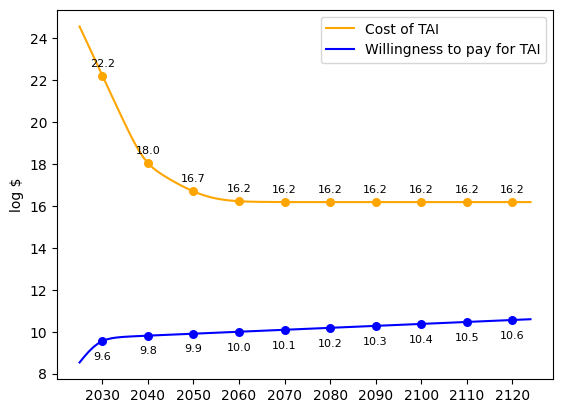

-
-
## SAMPLE RUN 28 ##

In this simulation:
* It takes 26.5 log FLOP (~316.2 septillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.1 quintillion) per 2025$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~5.6 sextillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.3 billion).
* This doubles every 0.7 year to a max of 0.032454% of GDP (initially ~8.1 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 26.5 logFLOP which costs 8.2 log 2025$USD to buy vs. WTP at 9.2 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 16 years (total delay 20 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occ

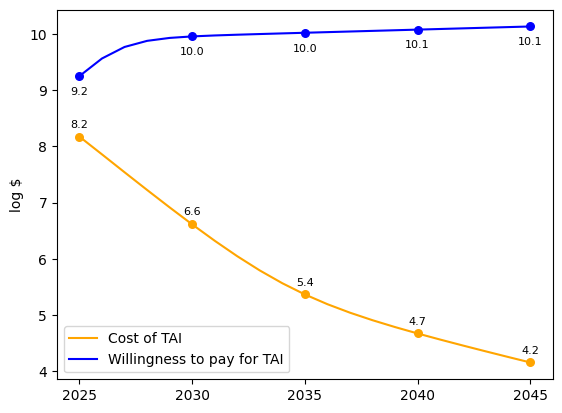

-
-
## SAMPLE RUN 29 ##

In this simulation:
* It takes 27.2 log FLOP (~1.6 octillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~13.5 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~15.9 sextillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.6 billion).
* This doubles every 1.0 year to a max of 0.055462% of GDP (initially ~13.9 billion 2025$USD).
* GDP grows at a rate of 1.014x per year.
---
2025 - TAI takes 27.2 logFLOP which costs 8.1 log 2025$USD to buy vs. WTP at 9.3 (buys 28.5 log FLOP or 28.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- this delay is 1 years (total delay 5 years)

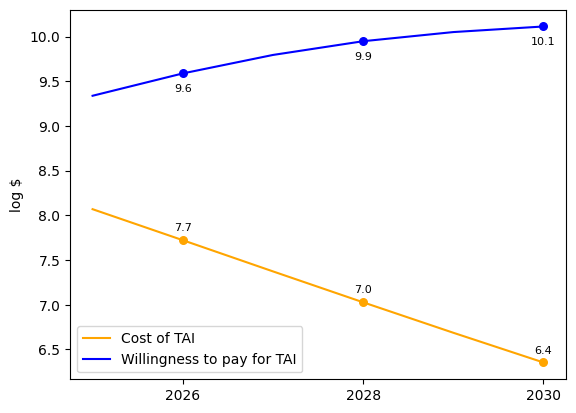

-
-
## SAMPLE RUN 30 ##

In this simulation:
* It takes 26.2 log FLOP (~158.5 septillion) for transformative capabilities.
* Every 2.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.3 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~438.3 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~389.0 million).
* This doubles every 1.8 year to a max of 0.067557% of GDP (initially ~17.0 billion 2025$USD).
* GDP grows at a rate of 1.038x per year.
---
2025 - TAI takes 26.2 logFLOP which costs 7.6 log 2025$USD to buy vs. WTP at 8.6 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 8 y

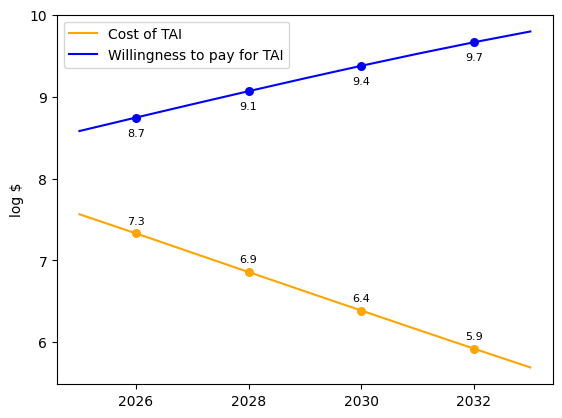

-
-
## SAMPLE RUN 31 ##

In this simulation:
* It takes 34.9 log FLOP (~79.4 decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.6 log FLOP (~35.6 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 25.6 log FLOP (~41.6 septillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.5 billion).
* This doubles every 0.7 year to a max of 0.022901% of GDP (initially ~5.7 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 34.9 logFLOP which costs 15.3 log 2025$USD to buy vs. WTP at 9.1 (buys 28.6 log FLOP or 28.6 2025-log-eFLOP)
2026 - TAI takes 34.5 logFLOP which costs 14.9 log 2025$USD to buy vs. WTP at 9.4 (buys 29.1 log FLOP or 29.4 2025-log-eFLOP)
2027 - TAI takes 34.2 logFLOP which costs 14.4 log 2025$USD to buy vs. WTP at 9.6 (buys 29.4 log FLOP or 30.1 2025-log-eFLOP)
2028 - TAI takes 33.8 logFLOP which costs 

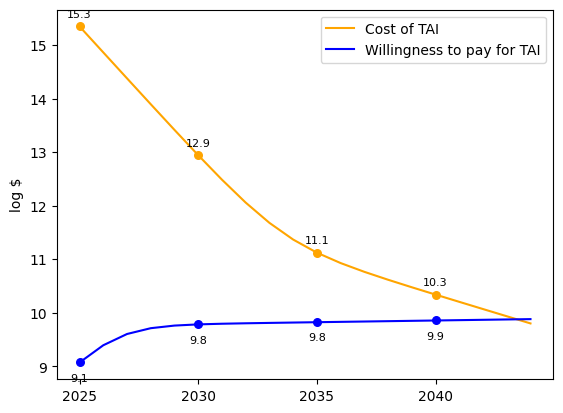

-
-
## SAMPLE RUN 32 ##

In this simulation:
* It takes 36.6 log FLOP (~4.0 thousand decillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.5 quintillion) per 2025$USD.
* Every 1.9 years they get 2x cheaper, to a maximum of 20.9 log FLOP (~780.2 quintillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~389.8 million).
* This doubles every 0.5 year to a max of 0.074593% of GDP (initially ~18.7 billion 2025$USD).
* GDP grows at a rate of 1.013x per year.
---
2025 - TAI takes 36.6 logFLOP which costs 18.4 log 2025$USD to buy vs. WTP at 8.6 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 36.4 logFLOP which costs 18.0 log 2025$USD to buy vs. WTP at 9.1 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 36.1 logFLOP which costs 17.6 log 2025$USD to buy vs. WTP at 9.6 (buys 28.1 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 35.9 logFLOP 

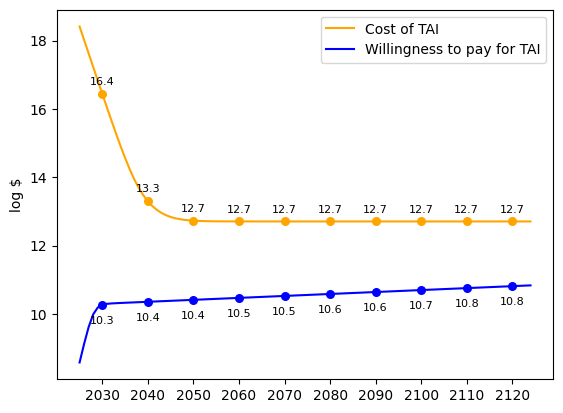

-
-
## SAMPLE RUN 33 ##

In this simulation:
* It takes 35.0 log FLOP (~100.0 decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.7 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~9.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~1.9 billion).
* This doubles every 1.3 year to a max of 0.104688% of GDP (initially ~26.4 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 35.0 logFLOP which costs 16.2 log 2025$USD to buy vs. WTP at 9.2 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 34.7 logFLOP which costs 15.8 log 2025$USD to buy vs. WTP at 9.5 (buys 28.4 log FLOP or 28.7 2025-log-eFLOP)
2027 - TAI takes 34.5 logFLOP which costs 15.4 log 2025$USD to buy vs. WTP at 9.7 (buys 28.7 log FLOP or 29.3 2025-log-eFLOP)
2028 - TAI takes 34.2 logFLOP which costs 

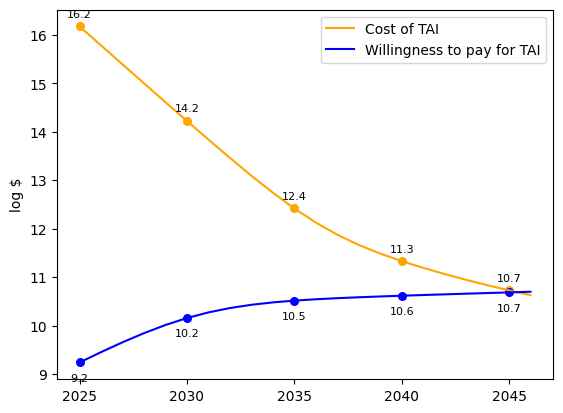

-
-
## SAMPLE RUN 34 ##

In this simulation:
* It takes 29.2 log FLOP (~158.5 octillion) for transformative capabilities.
* Every 2.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~672.7 quadrillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~778.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~607.0 million).
* This doubles every 1.5 year to a max of 0.063828% of GDP (initially ~16.0 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 29.2 logFLOP which costs 11.4 log 2025$USD to buy vs. WTP at 8.8 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 29.1 logFLOP which costs 11.1 log 2025$USD to buy vs. WTP at 9.0 (buys 26.9 log FLOP or 27.0 2025-log-eFLOP)
2027 - TAI takes 29.0 logFLOP which costs 10.9 log 2025$USD to buy vs. WTP at 9.1 (buys 27.3 log FLOP or 27.5 2025-log-eFLOP)
2028 - TAI takes 28.9 logFLOP which 

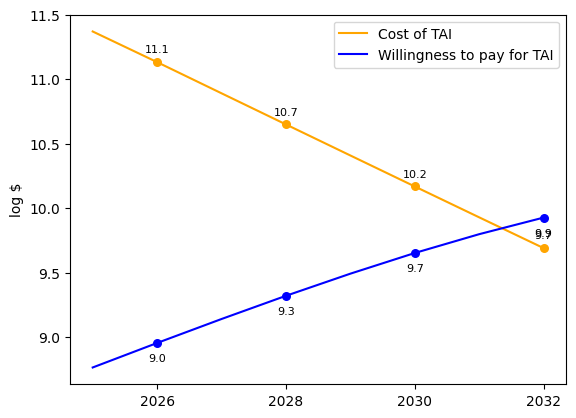

-
-
## SAMPLE RUN 35 ##

In this simulation:
* It takes 46.4 log FLOP (~25.1 trillion decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 6 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.0 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 25.0 log FLOP (~9.6 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~577.8 million).
* This doubles every 1.1 year to a max of 0.027284% of GDP (initially ~6.9 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 46.4 logFLOP which costs 28.4 log 2025$USD to buy vs. WTP at 8.7 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
2026 - TAI takes 46.0 logFLOP which costs 27.9 log 2025$USD to buy vs. WTP at 9.0 (buys 27.1 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 45.6 logFLOP which costs 27.4 log 2025$USD to buy vs. WTP at 9.2 (buys 27.4 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 45.2 logFLOP whic

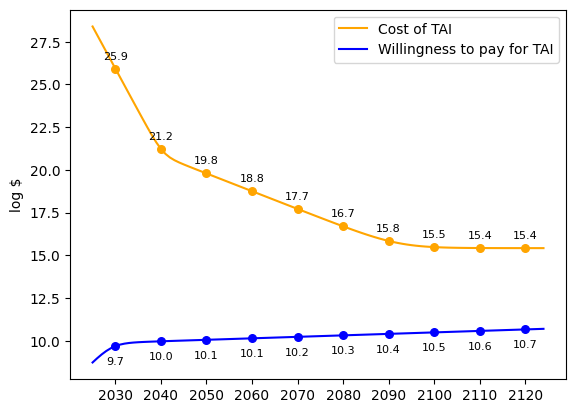

-
-
## SAMPLE RUN 36 ##

In this simulation:
* It takes 38.1 log FLOP (~125.9 thousand decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.3 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~746.6 million).
* This doubles every 1.1 year to a max of 0.007393% of GDP (initially ~1.8 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 38.1 logFLOP which costs 19.7 log 2025$USD to buy vs. WTP at 8.7 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 37.8 logFLOP which costs 19.3 log 2025$USD to buy vs. WTP at 8.9 (buys 27.4 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 37.5 logFLOP which costs 18.9 log 2025$USD to buy vs. WTP at 9.0 (buys 27.7 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 37.3 logFLOP wh

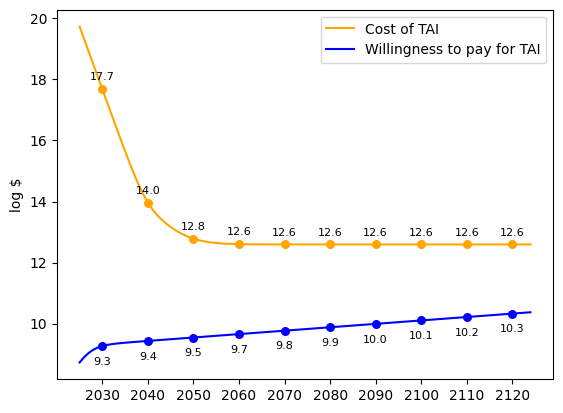

-
-
## SAMPLE RUN 37 ##

In this simulation:
* It takes 37.4 log FLOP (~25.1 thousand decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2.7 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.0 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~810.9 million).
* This doubles every 0.8 year to a max of 0.009039% of GDP (initially ~2.3 billion 2025$USD).
* GDP grows at a rate of 1.036x per year.
---
2025 - TAI takes 37.4 logFLOP which costs 18.9 log 2025$USD to buy vs. WTP at 8.8 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 37.0 logFLOP which costs 18.4 log 2025$USD to buy vs. WTP at 9.0 (buys 27.6 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 36.5 logFLOP which costs 17.8 log 2025$USD to buy vs. WTP at 9.2 (buys 27.9 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 36.1 logFLOP w

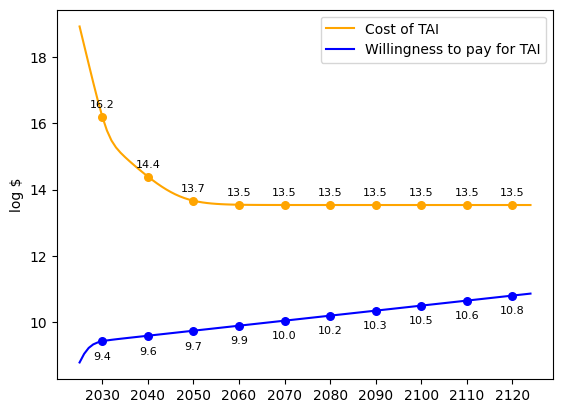

-
-
## SAMPLE RUN 38 ##

In this simulation:
* It takes 27.0 log FLOP (~1.0 octillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~922.9 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~58.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~815.0 million).
* This doubles every 0.6 year to a max of 0.017621% of GDP (initially ~4.4 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 27.0 logFLOP which costs 9.0 log 2025$USD to buy vs. WTP at 8.8 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 26.7 logFLOP which costs 8.6 log 2025$USD to buy vs. WTP at 9.2 (buys 27.3 log FLOP or 27.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6988 -> Nonscaling issue did not occur
-- data p_nonscaling_

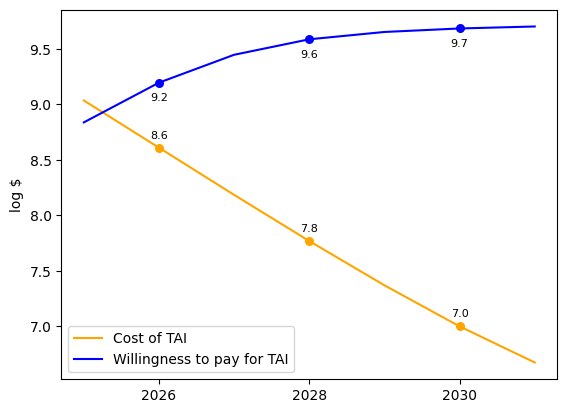

-
-
## SAMPLE RUN 39 ##

In this simulation:
* It takes 26.3 log FLOP (~199.5 septillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~2.9 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 25.8 log FLOP (~56.4 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~771.3 million).
* This doubles every 0.5 year to a max of 0.013512% of GDP (initially ~3.4 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 26.3 logFLOP which costs 7.8 log 2025$USD to buy vs. WTP at 8.8 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 5 

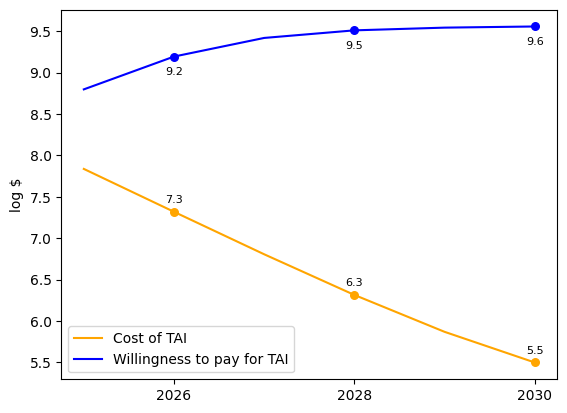

-
-
## SAMPLE RUN 40 ##

In this simulation:
* It takes 26.6 log FLOP (~398.1 septillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~470.8 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~836.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~685.9 million).
* This doubles every 1.9 year to a max of 0.01968% of GDP (initially ~5.0 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 26.6 logFLOP which costs 8.9 log 2025$USD to buy vs. WTP at 8.8 (buys 26.5 log FLOP or 26.5 2025-log-eFLOP)
2026 - TAI takes 26.5 logFLOP which costs 8.7 log 2025$USD to buy vs. WTP at 8.9 (buys 26.7 log FLOP or 26.9 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6988 -> Nonscaling delay occured
-- -- this delay is 6 ye

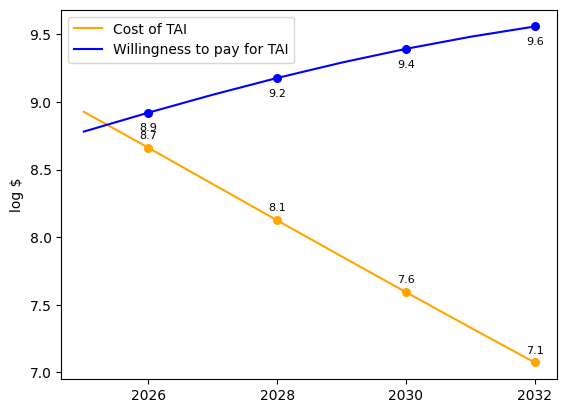

-
-
## SAMPLE RUN 41 ##

In this simulation:
* It takes 32.9 log FLOP (~794.3 nonillion) for transformative capabilities.
* Every 2.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.9 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 25.5 log FLOP (~31.1 septillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~300.9 million).
* This doubles every 1.2 year to a max of 0.024731% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 32.9 logFLOP which costs 14.1 log 2025$USD to buy vs. WTP at 8.5 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 32.8 logFLOP which costs 13.9 log 2025$USD to buy vs. WTP at 8.7 (buys 27.6 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 32.7 logFLOP which costs 13.6 log 2025$USD to buy vs. WTP at 8.9 (buys 28.0 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 32.6 logFLOP which cost

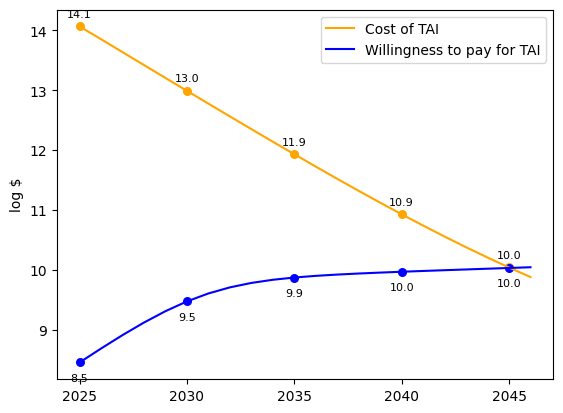

-
-
## SAMPLE RUN 42 ##

In this simulation:
* It takes 29.7 log FLOP (~501.2 octillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.1 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~51.4 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.0 billion).
* This doubles every 1.1 year to a max of 0.020151% of GDP (initially ~5.1 billion 2025$USD).
* GDP grows at a rate of 1.034x per year.
---
2025 - TAI takes 29.7 logFLOP which costs 10.8 log 2025$USD to buy vs. WTP at 8.9 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 29.3 logFLOP which costs 10.2 log 2025$USD to buy vs. WTP at 9.2 (buys 28.2 log FLOP or 28.6 2025-log-eFLOP)
2027 - TAI takes 28.8 logFLOP which costs 9.7 log 2025$USD to buy vs. WTP at 9.3 (buys 28.5 log FLOP or 29.4 2025-log-eFLOP)
2028 - TAI takes 28.5 logFLOP which costs 9

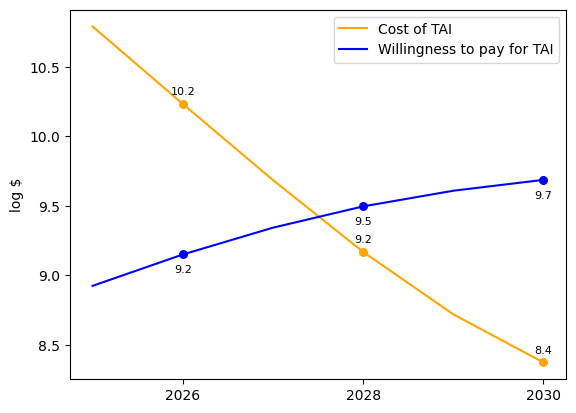

-
-
## SAMPLE RUN 43 ##

In this simulation:
* It takes 31.0 log FLOP (~10.0 nonillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.3 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~27.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~424.9 million).
* This doubles every 0.4 year to a max of 0.011212% of GDP (initially ~2.8 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 31.0 logFLOP which costs 12.4 log 2025$USD to buy vs. WTP at 8.6 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 30.6 logFLOP which costs 11.9 log 2025$USD to buy vs. WTP at 9.1 (buys 27.9 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 30.2 logFLOP which costs 11.4 log 2025$USD to buy vs. WTP at 9.4 (buys 28.2 log FLOP or 29.0 2025-log-eFLOP)
2028 - TAI takes 29.9 logFLOP which costs

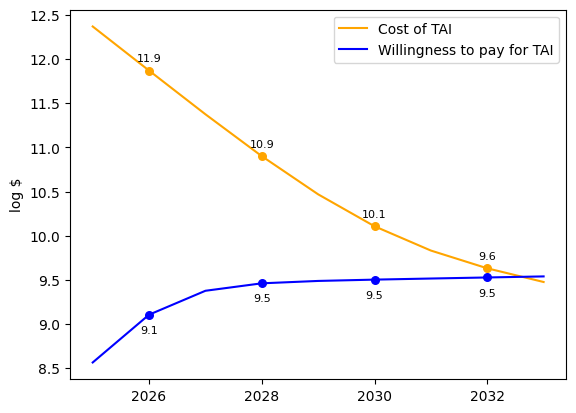

-
-
## SAMPLE RUN 44 ##

In this simulation:
* It takes 31.6 log FLOP (~39.8 nonillion) for transformative capabilities.
* Every 2.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.9 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~22.4 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.0 billion).
* This doubles every 0.7 year to a max of 0.011362% of GDP (initially ~2.9 billion 2025$USD).
* GDP grows at a rate of 1.007x per year.
---
2025 - TAI takes 31.6 logFLOP which costs 13.3 log 2025$USD to buy vs. WTP at 8.9 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 31.5 logFLOP which costs 13.1 log 2025$USD to buy vs. WTP at 9.2 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 31.3 logFLOP which costs 12.8 log 2025$USD to buy vs. WTP at 9.3 (buys 27.8 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 31.2 logFLOP which costs 1

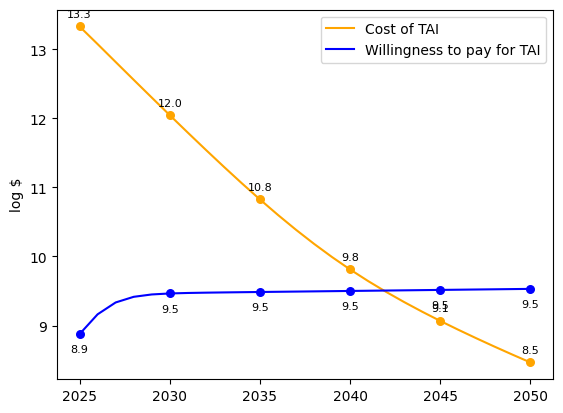

-
-
## SAMPLE RUN 45 ##

In this simulation:
* It takes 27.3 log FLOP (~2.0 octillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.8 quintillion) per 2025$USD.
* Every 1.9 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~2.8 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.1 billion).
* This doubles every 1.1 year to a max of 0.013525% of GDP (initially ~3.4 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 27.3 logFLOP which costs 8.4 log 2025$USD to buy vs. WTP at 8.9 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 21 years (total delay 21 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 22 years)

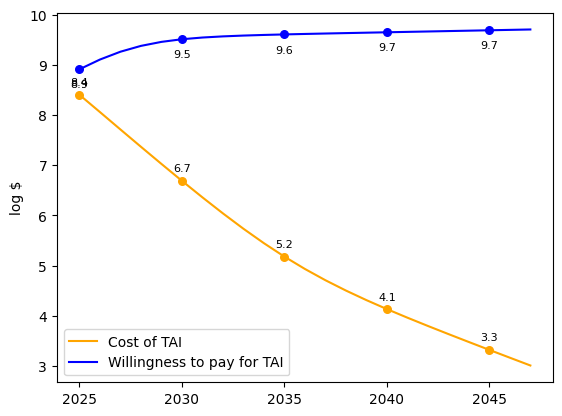

-
-
## SAMPLE RUN 46 ##

In this simulation:
* It takes 26.5 log FLOP (~316.2 septillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.2 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~24.8 sextillion) per 2025$USD.
* We are initially willing to pay 9.6 log 2025$USD (~3.6 billion).
* This doubles every 1.4 year to a max of 0.02031% of GDP (initially ~5.1 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 26.5 logFLOP which costs 8.4 log 2025$USD to buy vs. WTP at 9.3 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 8 years (total delay 8 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 8 mor

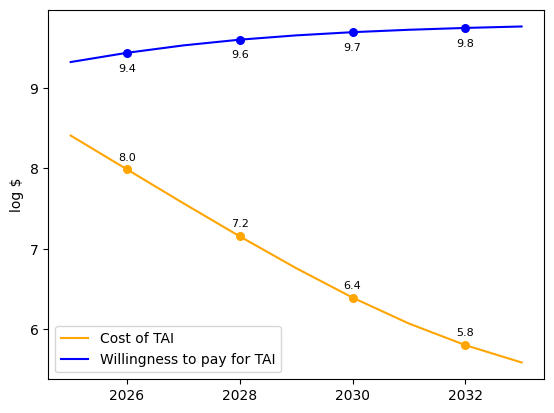

-
-
## SAMPLE RUN 47 ##

In this simulation:
* It takes 26.7 log FLOP (~501.2 septillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~876.7 quadrillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~93.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~592.7 million).
* This doubles every 1.1 year to a max of 0.009312% of GDP (initially ~2.3 billion 2025$USD).
* GDP grows at a rate of 1.036x per year.
---
2025 - TAI takes 26.7 logFLOP which costs 8.8 log 2025$USD to buy vs. WTP at 8.7 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 26.6 logFLOP which costs 8.5 log 2025$USD to buy vs. WTP at 8.9 (buys 27.0 log FLOP or 27.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6988 -> Nonscaling issue did not occur
-- data p_nonscali

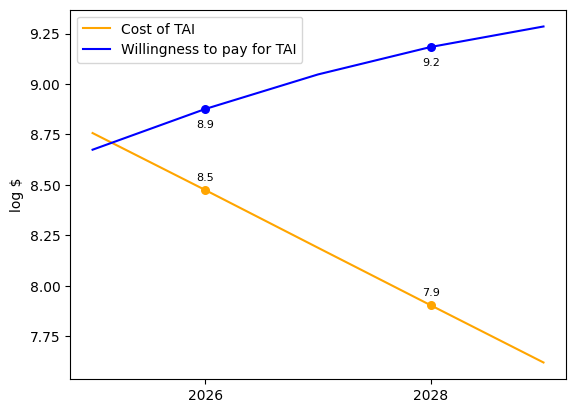

-
-
## SAMPLE RUN 48 ##

In this simulation:
* It takes 37.2 log FLOP (~15.8 thousand decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.0 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5.4 septillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~2.0 billion).
* This doubles every 1.4 year to a max of 0.02306% of GDP (initially ~5.8 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 37.2 logFLOP which costs 18.5 log 2025$USD to buy vs. WTP at 9.2 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 36.9 logFLOP which costs 18.1 log 2025$USD to buy vs. WTP at 9.3 (buys 28.1 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 36.6 logFLOP which costs 17.7 log 2025$USD to buy vs. WTP at 9.5 (buys 28.4 log FLOP or 29.0 2025-log-eFLOP)
2028 - TAI takes 36.3 logFLOP which 

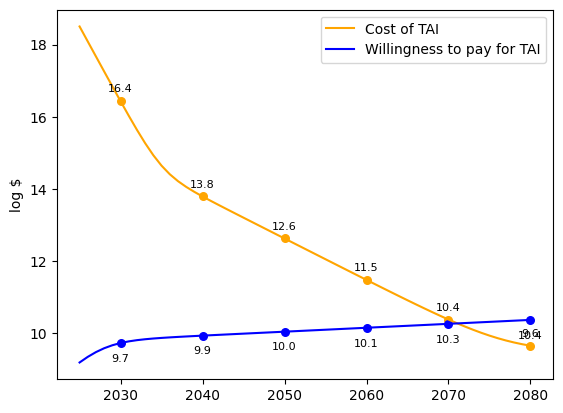

-
-
## SAMPLE RUN 49 ##

In this simulation:
* It takes 24.2 log FLOP (~1.6 septillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.3 quintillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~6.2 septillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.3 billion).
* This doubles every 1.5 year to a max of 0.014249% of GDP (initially ~3.6 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 24.2 logFLOP which costs 5.8 log 2025$USD to buy vs. WTP at 9.1 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 6 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- t

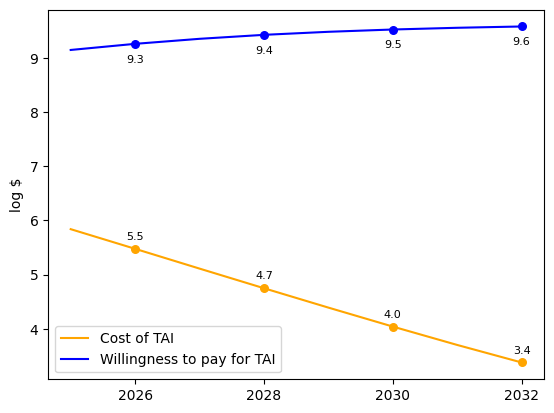

-
-
## SAMPLE RUN 50 ##

In this simulation:
* It takes 33.9 log FLOP (~7.9 decillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.2 quintillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~191.5 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~249.9 million).
* This doubles every 0.3 year to a max of 0.202731% of GDP (initially ~50.4 billion 2025$USD).
* GDP grows at a rate of 1.035x per year.
---
2025 - TAI takes 33.9 logFLOP which costs 15.8 log 2025$USD to buy vs. WTP at 8.4 (buys 26.5 log FLOP or 26.5 2025-log-eFLOP)
2026 - TAI takes 33.7 logFLOP which costs 15.5 log 2025$USD to buy vs. WTP at 9.3 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 33.5 logFLOP which costs 15.1 log 2025$USD to buy vs. WTP at 10.1 (buys 28.4 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 33.3 logFLOP which cos

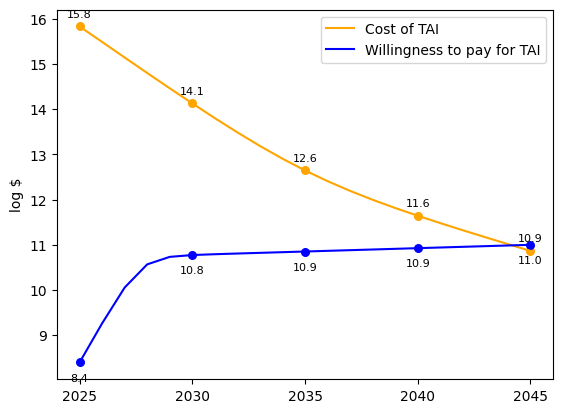

-
-
## SAMPLE RUN 51 ##

In this simulation:
* It takes 30.1 log FLOP (~1.3 nonillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.9 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~69.5 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~856.4 million).
* This doubles every 2.2 year to a max of 0.023789% of GDP (initially ~6.0 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 30.1 logFLOP which costs 11.4 log 2025$USD to buy vs. WTP at 8.9 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 29.9 logFLOP which costs 11.1 log 2025$USD to buy vs. WTP at 9.0 (buys 27.8 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 29.7 logFLOP which costs 10.8 log 2025$USD to buy vs. WTP at 9.1 (buys 28.0 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 29.5 logFLOP which costs 

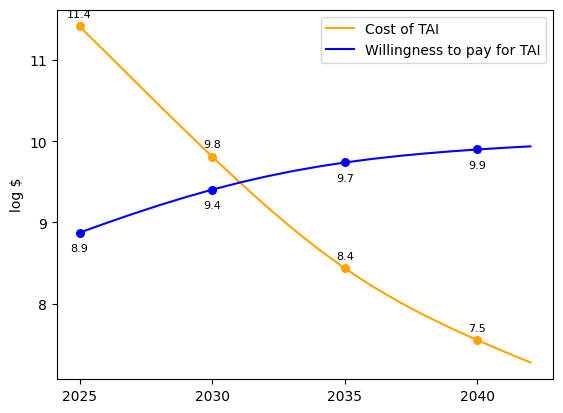

-
-
## SAMPLE RUN 52 ##

In this simulation:
* It takes 36.6 log FLOP (~4.0 thousand decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.0 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.9 log FLOP (~8.6 septillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~1.8 billion).
* This doubles every 1.3 year to a max of 0.011505% of GDP (initially ~2.9 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 36.6 logFLOP which costs 18.3 log 2025$USD to buy vs. WTP at 9.0 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 36.1 logFLOP which costs 17.7 log 2025$USD to buy vs. WTP at 9.2 (buys 27.6 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 35.6 logFLOP which costs 17.0 log 2025$USD to buy vs. WTP at 9.3 (buys 27.8 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 35.1 logFLOP which 

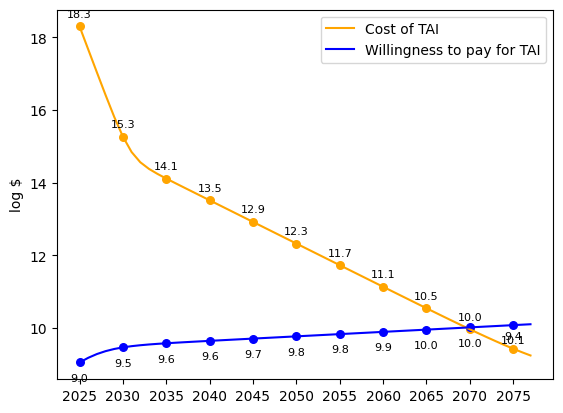

-
-
## SAMPLE RUN 53 ##

In this simulation:
* It takes 43.7 log FLOP (~50.1 billion decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 4.7 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.3 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~262.9 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 0.8 year to a max of 0.005092% of GDP (initially ~1.3 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 43.7 logFLOP which costs 24.9 log 2025$USD to buy vs. WTP at 8.8 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 43.4 logFLOP which costs 24.5 log 2025$USD to buy vs. WTP at 9.0 (buys 27.9 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 43.2 logFLOP which costs 24.1 log 2025$USD to buy vs. WTP at 9.1 (buys 28.1 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 42.9 logFLOP wh

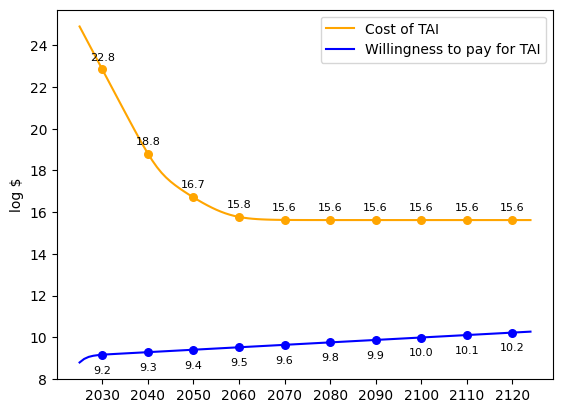

In [16]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [17]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2024-06-13 23:12:13.287753
